# Notes about simulation:

# Import packages and set settings

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(1, '../../python_modules')
import plotting
import model_supp 
import model
import saving

In [2]:
%matplotlib inline

# import pathlib
import seaborn as sns
import matplotlib.pyplot as plt
# import pickle
import numpy as np
# import math
import pandas as pd
from scipy.integrate import odeint
# from scipy.integrate import solve_ivp
# import os
import itertools
from scipy.optimize import fsolve

In [3]:
# plt.style.use("seaborn-whitegrid")
plt.rcParams['figure.figsize'] = [10.0, 8.0]
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['grid.linestyle'] = '-'
plt.rcParams['legend.fontsize'] = 14
colors = [i['color'] for i in plt.rcParams['axes.prop_cycle']]

# Load experimental data

In [29]:
wt_folder = 'C:/Users/sksuzuki/Desktop/killdevil/data/MAPK activation/WT'
t100a_folder = 'C:/Users/sksuzuki/Desktop/killdevil/data/MAPK activation/T100A'
pbs2_folder = 'C:/Users/sksuzuki/Desktop/killdevil/data/MAPK activation/Pbs2'
pbs2_t100a_folder = 'C:/Users/sksuzuki/Desktop/killdevil/data/MAPK activation/Pbs2_T100A'
# sho1DD_folder = 'C:/Users/sksuzuki/Desktop/killdevil/data/MAPK activation/sho1DD'
# ssk1D_folder = 'C:/Users/sksuzuki/Desktop/killdevil/data/MAPK activation/ssk1D'
hog1_ramp_folder =  'C:/Users/sksuzuki/Desktop/killdevil/data/MAPK activation/ramp_1'
pbs2_ramp_folder =  'C:/Users/sksuzuki/Desktop/killdevil/data/MAPK activation/ramp_1_pbs2'
ptpD_folder = 'C:/Users/sksuzuki/Desktop/killdevil/data/MAPK activation/ptpD'

mapk_time, mapk_wt_data = model_supp.load_csv_data(wt_folder)
mapk_time, mapk_t100a_data = model_supp.load_csv_data(t100a_folder)
mapk_data_t100a_long = [mapk_t100a_data[0]] 
mapk_time_t100a_long = [0, 2, 5, 10, 15, 20, 25, 30, 60, 90, 120, 150, 180, 240, 300]

mapk_time, map2k_wt_data = model_supp.load_csv_data(pbs2_folder)
mapk_time, map2k_t100a_data = model_supp.load_csv_data(pbs2_t100a_folder)
mapk_time, mapk_ptp_data = model_supp.load_csv_data(ptpD_folder)
# mapk_time, sho1_wt_data = load_csv_data(ssk1D_folder)
# mapk_time, sln1_wt_data = load_csv_data(sho1DD_folder)
mapk_ramp_time, hog1_ramp_data = model_supp.load_csv_data(hog1_ramp_folder)
mapk_ramp_time, pbs2_ramp_data = model_supp.load_csv_data(pbs2_ramp_folder)

# hog1_pulse_data = hog1_pulse_data[0]
# pbs2_pulse_data = pbs2_pulse_data[0]

# exclude far points
mapk_t100a_data = [mapk_t100a_data[0][:9]] + mapk_t100a_data[1:]

# Model Variables (Constants)

In [5]:
dt = 0.1
steps = 601
time = np.linspace(0,dt*steps,steps)

gen = 1000
runs = 2000

MAP3K_t = model_supp.molarity_conversion(701)
MAP2K_t = model_supp.molarity_conversion(2282)
MAPK_t = model_supp.molarity_conversion(5984)
PTP_t = model_supp.molarity_conversion(118+400)

MAP3K = 0.05*MAP3K_t # estimated (so not 0)
MAP2K = 0.05975380333*MAP2K_t # from the biological data
MAPK = 0.00540042381*MAPK_t  # from the biological data
gly = 0.00001 # placeholder (so not 0)
PTP = model_supp.molarity_conversion(118+400) # start with all on

PTP = model_supp.molarity_conversion(118+400)


labelnames = ['$- fb_1$', '$kb$',
              '$k_1$', '$k_3$', '$k_5$', '$s_1$',
              '$k_2$', '$k_4$', '$k_6$', '$d_1$',
              '$K_{M1}$', '$K_{M3}$', '$K_{M5}$',
              '$K_{M2}$', '$K_{M4}$', '$K_{M6}$']


minimums = [-4, -4,
        -4, -4, -4, -4,
        -4, -4, -4, -4, 
        -4, -4, -4, 
        -4, -4, -4]

maximums = [ 4, 4, 
        4, 4, 4, 4,
        4, 4, 4, 4, 
        4, 4, 4,
        4, 4, 4]

diff = np.asarray(maximums)-np.asarray(minimums)
dims = (diff, minimums)


initials = [MAP3K, MAP2K, MAPK, gly]
params_constants = [MAP3K_t, MAP2K_t, MAPK_t, 1] 


doses = [0, 50000, 150000, 250000, 350000, 450000, 550000]
map2k_doses = [150000, 550000]

# M2

## M2 - fit to all Hog1 and Pbs2 data

**Notes** 

### Inputs

In [7]:
folder = 'C:/Users/sksuzuki/Desktop/killdevil/runs_for_paper/190924_kb_M2/'

# mapk_time_t100a_long = [0, 2, 5, 10, 15, 20, 25, 30, 60, 90, 120, 150, 180, 240, 300]

M2_fxns = model.Model(model.M2, model.simulate_t100a_experiment_M2)

model_folder = 'M2/'
sim_id = 'M2_f-all_'

In [8]:
if len(labelnames) == len(diff):
    print('Params and labels match')

Params and labels match


### Gather simulated data

In [9]:
idx_top_M2_all, top_params_M2_all, top, plt_top, new_params, params_from_file, mse_M2_all, last_mses_M2_all = model_supp.gather_simulated_data(folder, gen, runs, 0.01)
df_top_params = pd.DataFrame(top_params_M2_all)
df_top_params.columns = labelnames
df_top_params_log = df_top_params.apply(np.log10)
df_top_params_log_M_M2_all = df_top_params_log.melt(var_name='param', value_name='vals')

Number of runs collected: 1807
Best MSE: 3084.505466527344
Mean MSE of top 5%: 3320.6341817328816


### Plot

In [10]:
select_top_M2_all = top_params_M2_all.copy()
# select_top_M2_all = np.concatenate((select_top_[:7], select_top_M4[8:11]))

In [26]:
plotting.plt_param_behaviors(M2_fxns, select_top_M2_all, 10, params_constants, initials,  doses, time, 2, mapk_wt_data, mapk_t100a_data, mapk_time, save_fig=model_folder+sim_id+'hog1')
# plt.savefig("C:/Users/sksuzuki/Documents/Research/figures/simulations/hog1.png",dpi=150,bbox_inches='tight')

NameError: name 'M2_fxns' is not defined

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


<Figure size 720x576 with 0 Axes>

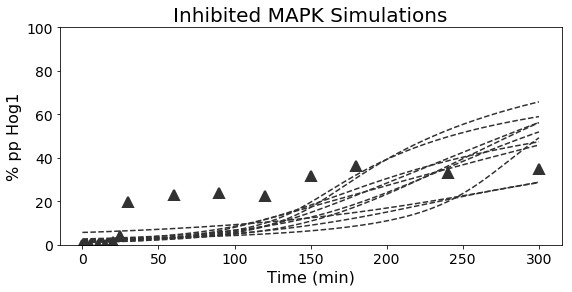

In [99]:
mapk_time_t100a_long = [0, 2, 5, 10, 15, 20, 25, 30, 60, 90, 120, 150, 180, 240, 300]

plotting.plt_t100a_long(M2_fxns, select_top_M2_all, 10, params_constants, initials, mapk_data_t100a_long[0], mapk_time_t100a_long, save_fig=model_folder+sim_id+'t100a_long')

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


<Figure size 720x576 with 0 Axes>

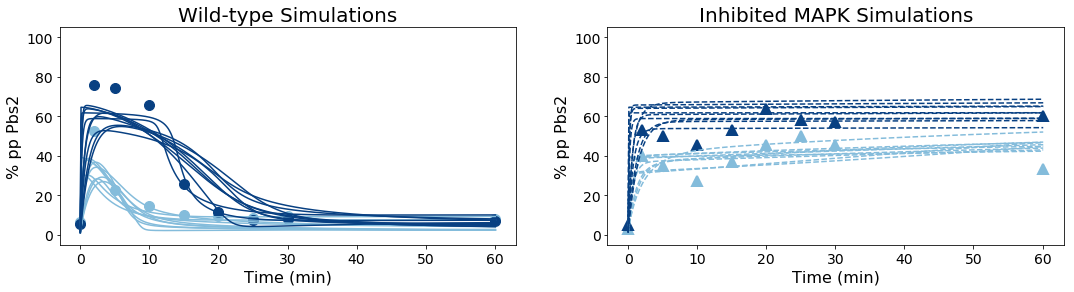

In [100]:
plotting.plt_param_behaviors(M2_fxns, select_top_M2_all, 10, params_constants, initials,  map2k_doses, time, 1, map2k_wt_data, map2k_t100a_data, mapk_time, save_fig=model_folder+sim_id+'pbs2')

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


<Figure size 720x576 with 0 Axes>

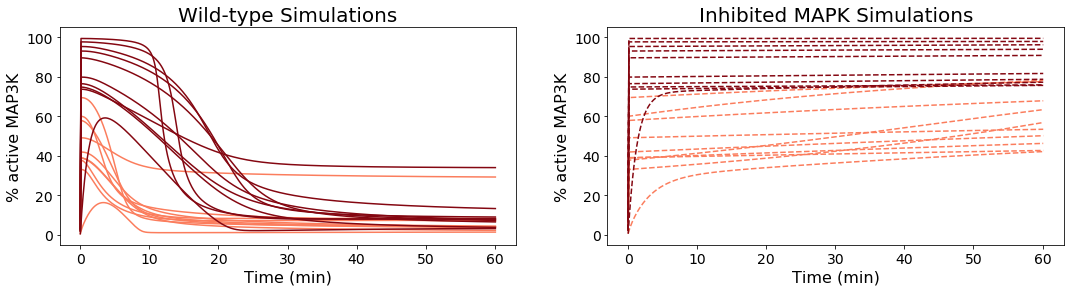

In [101]:
plotting.plt_param_behaviors(M2_fxns, top_params_M2_all, 10, params_constants, initials,  map2k_doses, time, 0, save_fig=model_folder+sim_id+'MAP3K')

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


<Figure size 720x576 with 0 Axes>

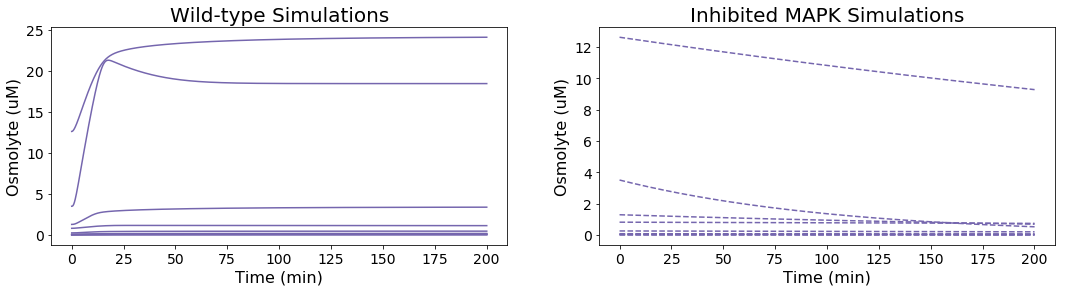

In [110]:
plotting.plt_param_behaviors(M2_fxns, top_params_M2_all, 10, params_constants, initials,  [350000], time, 3, save_fig=model_folder+sim_id+'Osmolytes')

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


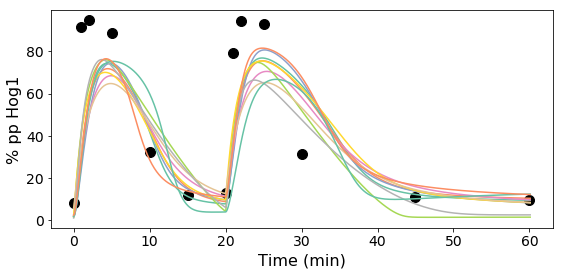

In [127]:
plotting.plt_ramp_behaviors(M2_fxns, top_params_M2_all, 10, params_constants, initials, time, 2, hog1_ramp_data, mapk_ramp_time, save_fig=model_folder+sim_id+'ramp')

<Figure size 720x576 with 0 Axes>

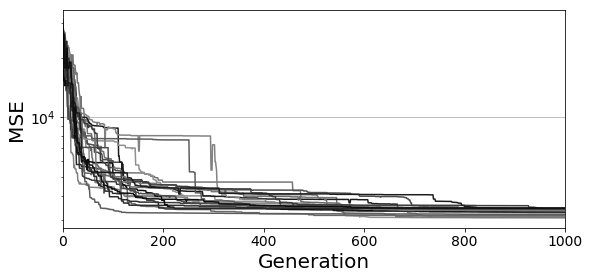

In [129]:
plotting.plt_mses_gen(gen,mse_M2_all, idx_top_M2_all, save_fig=model_folder+sim_id+'mses')

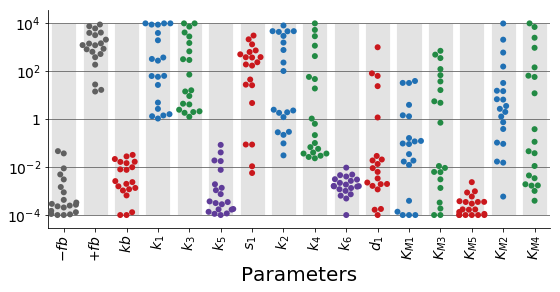

In [130]:
plotting.plt_param_ranges(labelnames, 'M2', dims, df_top_params_log_M_M2_all, save_fig=model_folder+sim_id+'params')

In [134]:
mses_M2_all = model_supp.get_mse_stats(M2_fxns, top_params_M2_all, params_constants, initials, ptpD=False)
mses_M2_all.head()

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


0          1           2           3           4           5   \
0  5.164534  16.407590  214.894542  226.107767  270.250703  287.826122   
1  5.050774  22.950741  271.389663  246.362646  257.400781  267.032250   
2  4.854047  14.070178  352.142131  297.490928  271.209524  257.432920   
3  6.322193  25.658479  331.148133  332.448746  339.523042  349.362463   
4  4.356977  12.518387  385.656737  203.217303  230.559185  261.858571   

           6           7           8           9           10          11  \
0  237.714403  145.905577  155.326124  350.271645   78.013100  193.624424   
1  194.848824  100.674772  137.291484  274.898422   81.971381  229.409039   
2  183.516515  173.050839  213.080849  165.852574   75.264033  197.667800   
3  264.116575  141.756747  166.618532  188.546445   65.570064  181.582911   
4  213.458922  152.311854  153.582011  307.818765  117.879859  221.341433   

           12          13          14         15          16          17  
0  209.744330  328.756572  222.104449  52.576474   28.138034  820.625200  
1  259.146845  413.363823   96.660752  56.526666  133.967221  751.242041  
2  218.981595  368.132781  172.501978  47.775273   56.024432  944.637608  
3  164.805641  302.383327  101.714531  50.559683  101.673226  899.570237  
4  286.426791  393.589415   47.240782  69.829821   66.315663  585.527968

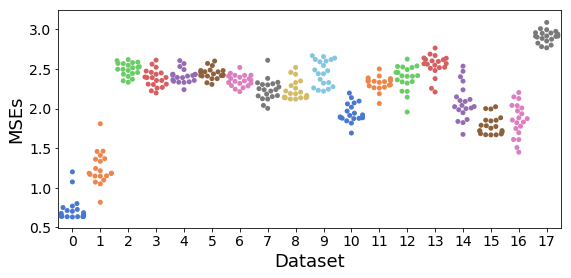

In [136]:
plotting.plt_mses_swarm(mses_M2_all, save_fig='')

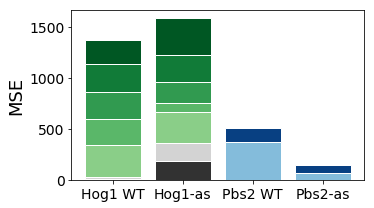

In [138]:
plotting.plt_mses(mses_M2_all, (1,1, 1, 1, 0,0), size=(5,3), ptpD=False ,save_fig=model_folder+sim_id+'fit_mses')

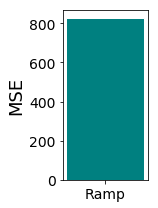

In [140]:
plotting.plt_mses(mses_M2_all, (0,0, 0, 0, 1, 1), size=(2,3), ptpD=False ,save_fig=model_folder+sim_id+'predicted_mses')

$+ fb$    $k_5$       0.605463
$k_5$     $+ fb$      0.605463
$- fb$    $s_1$       0.629005
$s_1$     $- fb$      0.629005
$k_6$     $k_2$       0.792034
$k_2$     $k_6$       0.792034
          $K_{M2}$    0.814501
$K_{M2}$  $k_2$       0.814501
$k_1$     $kb$        0.827684
$kb$      $k_1$       0.827684
dtype: float64


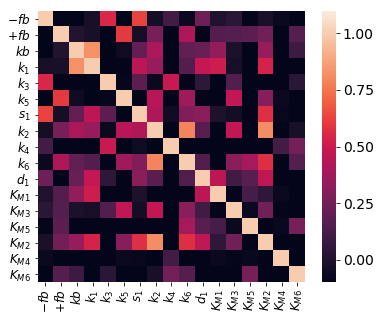

In [131]:
plotting.plt_corr(labelnames, df_top_params, save_fig=model_folder+sim_id+'corr')

### Save data 

In [141]:
# save_sim_data(select_top_M4, doses, 2, path='C:/Users/sksuzuki/Documents/Research/figures/paper1/unsorted/', sim_name='M4_wt')

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [143]:
# save_sim_data(select_top_M4, doses, 2, path='C:/Users/sksuzuki/Documents/Research/figures/paper1/unsorted/', sim_name='M4_t100a', t100a=True)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [151]:
# save_sim_data(select_top_M4, doses, 2, path='C:/Users/sksuzuki/Documents/Research/figures/paper1/unsorted/', sim_name='M4_ramp', ramp=True)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


# M2a

## Model Constant Params

In [9]:
folder = 'C:/Users/sksuzuki/Desktop/killdevil/runs_for_paper/191004_kb_M2a_hog1/'

gen = 1000
runs = 2000


labelnames = ['$- fb$', '$+ fb$', '$kb$',
              '$k_1$', '$k_3$', '$k_5$', '$s_1$',
              '$k_2$', '$k_4$', '$k_6$', '$d_1$',
              '$K_{M1}$', '$K_{M3}$', '$K_{M5}$',
              '$K_{M2}$', '$K_{M4}$', '$K_{M6}$']


minimums = [-4, -4, -4,
        -4, -4, -4, -4,
        -4, -4, -4, -4, 
        -4, -4, -4, 
        -4, -4, -4]

maximums = [ 4, 4, 4, 
        4, 4, 4, 4,
        4, 4, 4, 4, 
        4, 4, 4,
        4, 4, 4]

diff = np.asarray(maximums)-np.asarray(minimums)
dims = (diff, minimums)


M2a_fxns = model.Model(model.M2a_kb, model.simulate_t100a_experiment_M2a_kb, model.simulate_nopos_experiment_M2a_kb)



##  191004_kb_M2a_hog1.py

**Notes** 

### Inputs

In [ ]:
folder = 'C:/Users/sksuzuki/Desktop/killdevil/runs_for_paper/191004_kb_M2a_hog1/'

model_folder = 'M2a/'
sim_id = 'M2a_f-hog1_'

### Gather simulated data

In [200]:
idx_top_M2a_hog1, top_params_M2a_hog1, top, plt_top, new_params, params_from_file, mse_M2a_hog1, last_mses_M2a_hog1 = model_supp.gather_simulated_data(folder, gen, runs, 0.01)
df_top_params = pd.DataFrame(top_params_M2a_hog1)
df_top_params.columns = labelnames
df_top_params_log = df_top_params.apply(np.log10)
df_top_params_log_M_M2a_hog1 = df_top_params_log.melt(var_name='param', value_name='vals')

Number of runs collected: 1998
Best MSE: 2064.397976882752
Mean MSE of top 5%: 2671.005999626424


### Plot

In [201]:
select_top_M2a_hog1 = top_params_M2a_hog1.copy()
# select_top_M2_all = np.concatenate((select_top_[:7], select_top_M4[8:11]))

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1000.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


<Figure size 720x576 with 0 Axes>

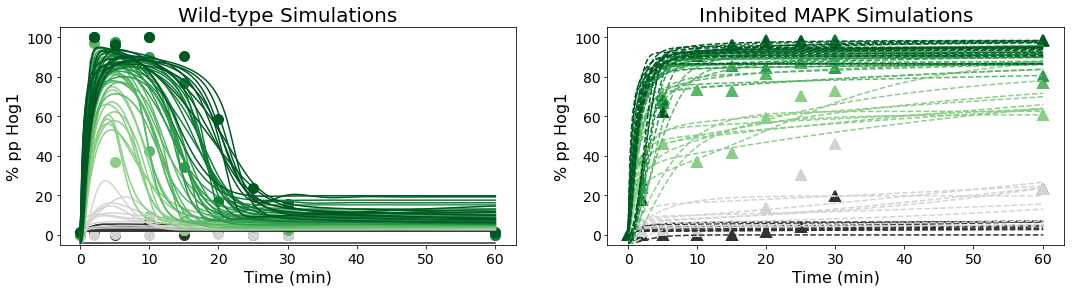

In [147]:
plotting.plt_param_behaviors(M2a_fxns, select_top_M2a_hog1, 10, params_constants, initials,  doses, time, 2, mapk_wt_data, mapk_t100a_data, mapk_time)# save_fig=model_folder+sim_id+'hog1')
# plt.savefig("C:/Users/sksuzuki/Documents/Research/figures/simulations/hog1.png",dpi=150,bbox_inches='tight')

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1000.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


<Figure size 720x576 with 0 Axes>

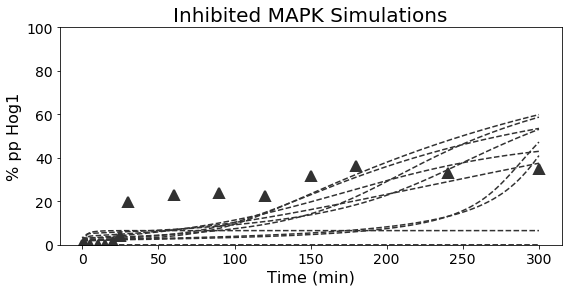

In [148]:
mapk_time_t100a_long = [0, 2, 5, 10, 15, 20, 25, 30, 60, 90, 120, 150, 180, 240, 300]

plotting.plt_t100a_long(M2a_fxns, select_top_M2a_hog1, 10, params_constants, initials, mapk_data_t100a_long[0], mapk_time_t100a_long, save_fig=model_folder+sim_id+'t100a_long')

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1000.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


<Figure size 720x576 with 0 Axes>

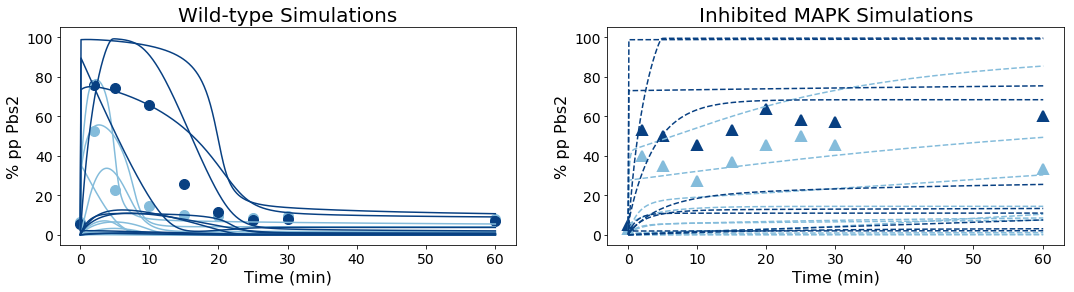

In [149]:
plotting.plt_param_behaviors(M2a_fxns, select_top_M2a_hog1, 10, params_constants, initials,  map2k_doses, time, 1, map2k_wt_data, map2k_t100a_data, mapk_time, save_fig=model_folder+sim_id+'pbs2')

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1000.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


<Figure size 720x576 with 0 Axes>

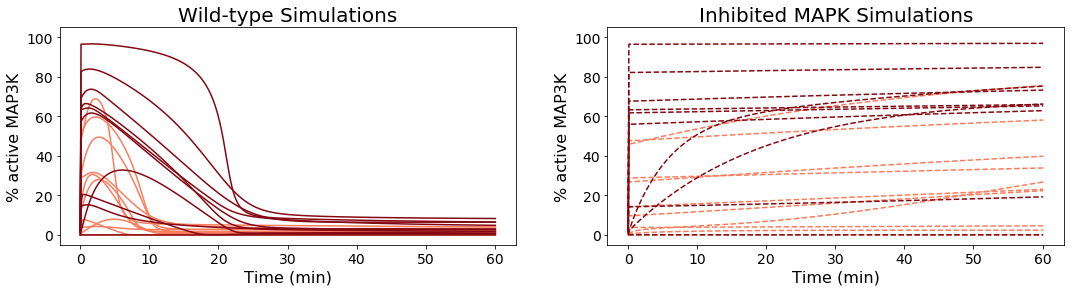

In [150]:
plotting.plt_param_behaviors(M2a_fxns, select_top_M2a_hog1, 10, params_constants, initials,  map2k_doses, time, 0, save_fig=model_folder+sim_id+'MAP3K')

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1000.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


<Figure size 720x576 with 0 Axes>

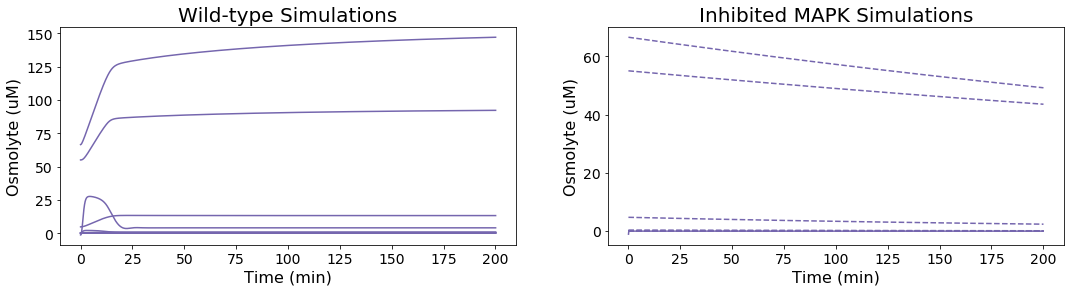

In [151]:
plotting.plt_param_behaviors(M2a_fxns, select_top_M2a_hog1, 10, params_constants, initials,  [350000], time, 3, save_fig=model_folder+sim_id+'Osmolytes')

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1000.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


<Figure size 720x576 with 0 Axes>

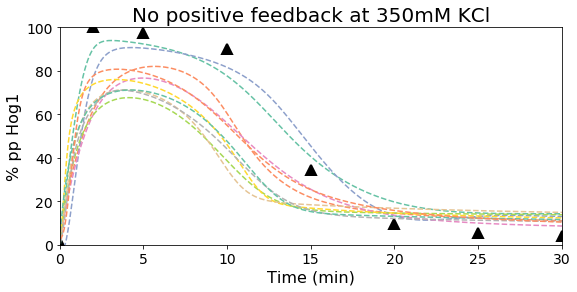

In [239]:
plotting.plt_nopos(M2a_fxns, select_top_M2a_hog1, 10, params_constants, initials, mapk_wt_data[4], mapk_time, 350000, save_fig='')

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1000.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


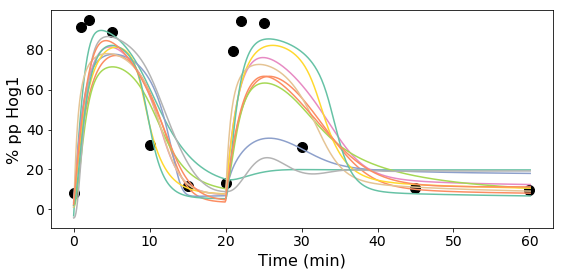

In [153]:
plotting.plt_ramp_behaviors(M2a_fxns, select_top_M2a_hog1, 10, params_constants, initials, time, 2, hog1_ramp_data, mapk_ramp_time, save_fig=model_folder+sim_id+'ramp')

<Figure size 720x576 with 0 Axes>

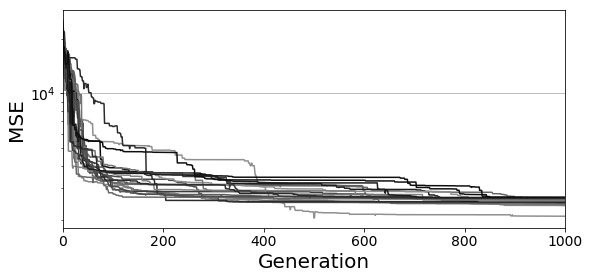

In [157]:
plotting.plt_mses_gen(gen,mse_M2a_hog1, idx_top_M2a_hog1, save_fig=model_folder+sim_id+'mses')

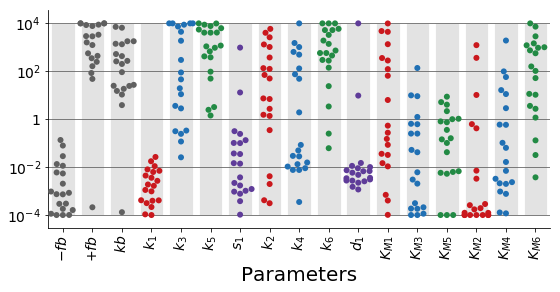

In [158]:
plotting.plt_param_ranges(labelnames, 'M2a', dims, df_top_params_log_M_M2a_hog1, save_fig=model_folder+sim_id+'params')

In [159]:
mses_M2a_hog1 = model_supp.get_mse_stats(M2a_fxns, top_params_M2a_hog1, params_constants, initials, ptpD=False)
mses_M2a_hog1.head()

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1000.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


0          1           2           3           4           5   \
0  10.765624  37.476815  293.622026  158.617947  106.277928  240.329715   
1   5.048706  43.138014  303.933184  240.189604  209.185351  212.921432   
2  11.386376  48.706711  297.652704  197.461525  126.523256  100.464337   
3   8.954262  27.367811  276.468743  157.174058  148.120653  171.101136   
4   7.731780  63.278288  342.737440  285.674363  234.473122  195.077743   

           6           7           8           9           10          11  \
0  391.786342  278.677630  152.943539  124.295320  144.080422   40.462529   
1  201.029076  128.263850  146.743746  127.108472   49.879000  192.799032   
2  114.859838   76.042529  180.511229  123.370376   63.339458  265.868184   
3  126.471031  151.350634  236.907830  127.419146   64.440228  251.800686   
4  135.459412   91.620759  158.274410  117.791067   48.509324  226.142665   

           12          13           14           15           16           17  
0   25.558704  104.464561   369.042715   642.156022   145.847222  1473.267984  
1  198.049102  353.823629  1368.554175  1021.933333  1683.172009   861.754291  
2  306.599925  539.429439  1317.299773  1187.241127  1170.565493  1192.245394  
3  269.111718  456.327173   162.250577    77.716164   337.795141   588.403278  
4  208.397014  380.654253  1796.851432  1395.957004  2438.028928   986.159309

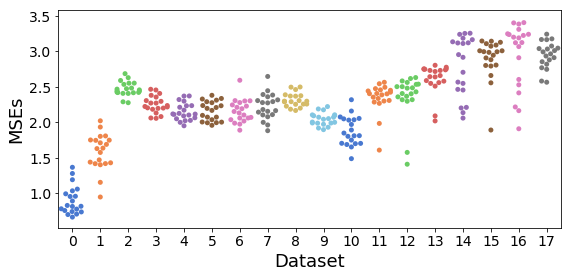

In [160]:
plotting.plt_mses_swarm(mses_M2a_hog1, save_fig='')

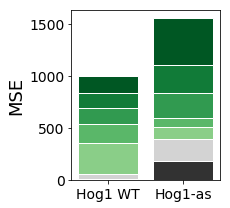

In [162]:
plotting.plt_mses(mses_M2a_hog1, (1,1, 0, 0, 0,0), size=(3,3), ptpD=False ,save_fig=model_folder+sim_id+'fit_mses')

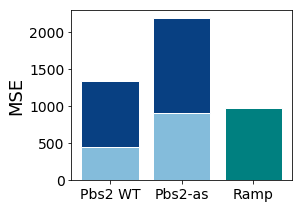

In [164]:
plotting.plt_mses(mses_M2a_hog1, (0,0, 1, 1, 1, 1), size=(4,3), ptpD=False ,save_fig=model_folder+sim_id+'predicted_mses')

$K_{M3}$  $K_{M5}$    0.764502
$K_{M5}$  $K_{M3}$    0.764502
$k_1$     $+ fb$      0.797651
$+ fb$    $k_1$       0.797651
$k_2$     $K_{M2}$    0.808016
$K_{M2}$  $k_2$       0.808016
$k_1$     $kb$        0.949675
$kb$      $k_1$       0.949675
$s_1$     $d_1$       0.999923
$d_1$     $s_1$       0.999923
dtype: float64


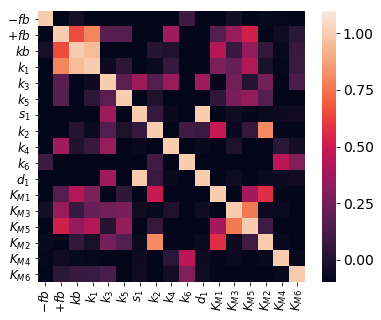

In [165]:
plotting.plt_corr(labelnames, df_top_params, save_fig=model_folder+sim_id+'corr')

##  191014_kb_M2a.py

**Notes** 

### Inputs

In [10]:
folder = 'C:/Users/sksuzuki/Desktop/killdevil/runs_for_paper/191014_kb_M2a/'

model_folder = 'M2a/'
sim_id = 'M2a_f-all_'

### Gather simulated data

In [11]:
idx_top_M2a_all, top_params_M2a_all, top, plt_top, new_params, params_from_file, mse_M2a_all, last_mses_M2a_all = model_supp.gather_simulated_data(folder, gen, runs, 0.01)
df_top_params = pd.DataFrame(top_params_M2a_all)
df_top_params.columns = labelnames
df_top_params_log = df_top_params.apply(np.log10)
df_top_params_log_M_M2a_all = df_top_params_log.melt(var_name='param', value_name='vals')

Number of runs collected: 2160
Best MSE: 2877.4083278395465
Mean MSE of top 5%: 3139.9050004385617


### Plot

In [12]:
select_top_M2a_all = top_params_M2a_all.copy()
# select_top_M2_all = np.concatenate((select_top_[:7], select_top_M4[8:11]))

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1000.
  warnings.warn(msg, RuntimeWarning)


<Figure size 720x576 with 0 Axes>

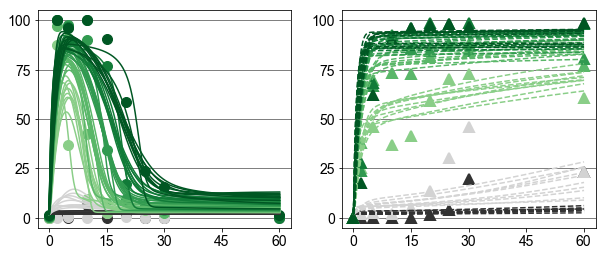

In [29]:
plotting.plt_param_behaviors(M2a_fxns, select_top_M2a_all, 10, params_constants, initials,  doses, time, 2, mapk_wt_data, mapk_t100a_data, mapk_time,ss=True)
# plotting.plt_param_behaviors(M2a_fxns, select_top_M2a_all, 10, params_constants, initials,  doses, time, 2, mapk_wt_data, mapk_t100a_data, mapk_time, save_fig=model_folder+sim_id+'hog1')

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1000.
  warnings.warn(msg, RuntimeWarning)


<Figure size 720x576 with 0 Axes>

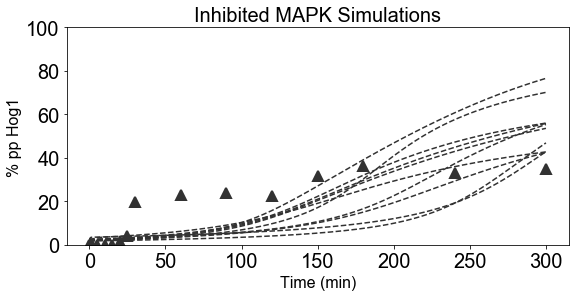

In [28]:
mapk_time_t100a_long = [0, 2, 5, 10, 15, 20, 25, 30, 60, 90, 120, 150, 180, 240, 300]
plotting.plt_t100a_long(M2a_fxns, select_top_M2a_all, 10, params_constants, initials, mapk_data_t100a_long[0], mapk_time_t100a_long)
# plotting.plt_t100a_long(M2a_fxns, select_top_M2a_all, 10, params_constants, initials, mapk_data_t100a_long[0], mapk_time_t100a_long, save_fig=model_folder+sim_id+'t100a_long')

ValueError: x and y must not be None

<Figure size 720x576 with 0 Axes>

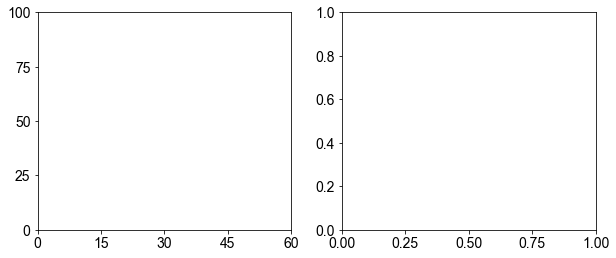

In [22]:
plotting.plt_param_behaviors(M2a_fxns, select_top_M2a_all, 10, params_constants, initials,  map2k_doses, time, 1, map2k_wt_data, map2k_t100a_data, mapk_time)
# plotting.plt_param_behaviors(M2a_fxns, select_top_M2a_all, 10, params_constants, initials,  map2k_doses, time, 1, map2k_wt_data, map2k_t100a_data, mapk_time, save_fig=model_folder+sim_id+'pbs2')

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1000.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


<Figure size 720x576 with 0 Axes>

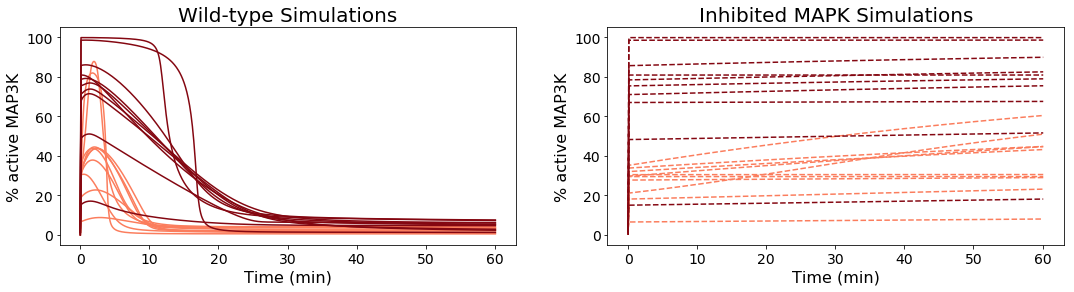

In [22]:
plotting.plt_param_behaviors(M2a_fxns, select_top_M2a_all, 10, params_constants, initials,  map2k_doses, time, 0)
# plotting.plt_param_behaviors(M2a_fxns, select_top_M2a_all, 10, params_constants, initials,  map2k_doses, time, 0, save_fig=model_folder+sim_id+'MAP3K')

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1000.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


<Figure size 720x576 with 0 Axes>

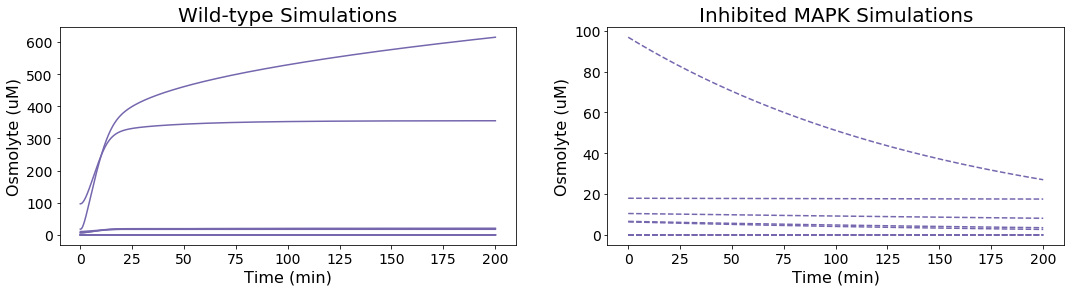

In [23]:
plotting.plt_param_behaviors(M2a_fxns, select_top_M2a_all, 10, params_constants, initials,  [350000], time, 3)
# plotting.plt_param_behaviors(M2a_fxns, select_top_M2a_all, 10, params_constants, initials,  [350000], time, 3, save_fig=model_folder+sim_id+'Osmolytes')

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1000.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


<Figure size 720x576 with 0 Axes>

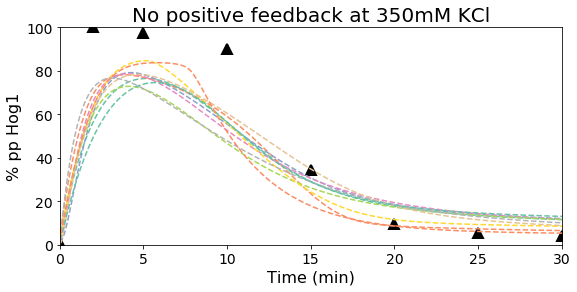

In [205]:
plotting.plt_nopos(M2a_fxns, select_top_M2a_all, 10, params_constants, initials, mapk_wt_data[4], mapk_time, 350000, save_fig='')

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1000.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


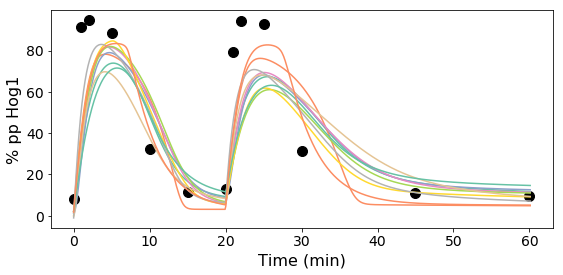

In [27]:
plotting.plt_ramp_behaviors(M2a_fxns, select_top_M2a_all, 10, params_constants, initials, time, 2, hog1_ramp_data, mapk_ramp_time)
# plotting.plt_ramp_behaviors(M2a_fxns, select_top_M2a_all, 10, params_constants, initials, time, 2, hog1_ramp_data, mapk_ramp_time, save_fig=model_folder+sim_id+'ramp')

<Figure size 720x576 with 0 Axes>

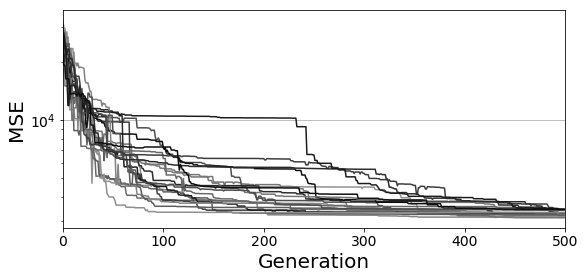

In [30]:
plotting.plt_mses_gen(gen,mse_M2a_all, idx_top_M2a_all)
# plotting.plt_mses_gen(gen,mse_M2a_all, idx_top_M2a_all, save_fig=model_folder+sim_id+'mses')

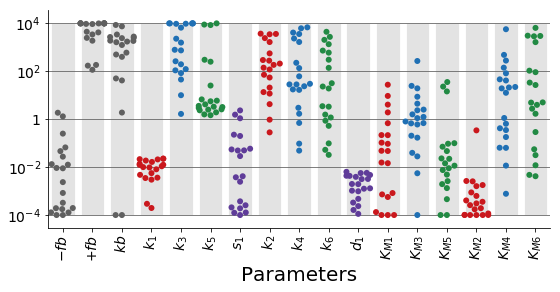

In [31]:
plotting.plt_param_ranges(labelnames, 'M2a', dims, df_top_params_log_M_M2a_all)
# plotting.plt_param_ranges(labelnames, 'M2a', dims, df_top_params_log_M_M2a_all, save_fig=model_folder+sim_id+'params')

In [36]:
mses_M2a_all = model_supp.get_mse_stats(M2a_fxns, top_params_M2a_all, params_constants, initials, ptpD=False)
mses_M2a_all.head()

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1000.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


0          1           2           3           4           5   \
0  4.957067  15.278394  306.142504  266.910152  286.335586  318.759755   
1  5.193048  18.754594  295.976146  160.843216  145.605134  143.782612   
2  7.228658  42.658408  377.572603  243.177323  242.512288  286.467057   
3  5.796222  42.558262  337.804332  177.180647  148.739303  185.169084   
4  5.633000  25.978821  420.597708  209.424164  174.101061  214.827358   

           6           7           8           9          10          11  \
0  264.714814  222.744857  258.042023  121.915001  72.824795  204.991463   
1  142.017249  229.607427  205.528178  162.833168  80.216044  287.778172   
2  227.649884  124.920838  154.009603  168.815537  58.735844  217.162474   
3  134.870165  114.646602  144.635948  133.564128  77.227111  290.162293   
4  185.669760  188.597671  216.724972   88.921034  42.714852  219.554187   

           12          13          14          15          16          17  
0  165.013599  306.790452   93.449148   51.865670  105.992867  853.930476  
1  390.653269  562.032376  145.997871   75.715835   40.402279  644.823341  
2  230.353892  400.040143  182.041807   56.152457   34.507920  971.696714  
3  313.304297  529.292051  227.925565  158.928564   48.755489  794.920797  
4  269.233393  463.381699   57.247333  101.365454  255.007868  940.341914

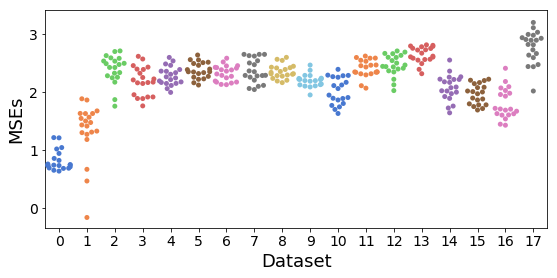

In [37]:
plotting.plt_mses_swarm(mses_M2a_all, save_fig='')

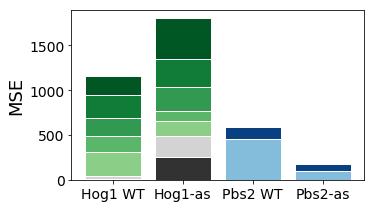

In [38]:
plotting.plt_mses(mses_M2a_all, (1,1, 1, 1, 0,0), size=(5,3), ptpD=False)
# plotting.plt_mses(mses_M2a_all, (1,1, 1, 1, 0,0), size=(5,3), ptpD=False ,save_fig=model_folder+sim_id+'fit_mses')

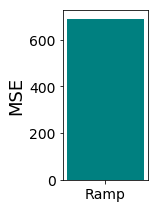

In [40]:
plotting.plt_mses(mses_M2a_all, (0,0, 0, 0, 1, 1), size=(2,3), ptpD=False)
# plotting.plt_mses(mses_M2a_hog1, (0,0, 0, 0, 1, 1), size=(2,3), ptpD=False ,save_fig=model_folder+sim_id+'predicted_mses')

$K_{M5}$  $k_5$       0.603440
$k_5$     $K_{M5}$    0.603440
$K_{M4}$  $K_{M5}$    0.774134
$K_{M5}$  $K_{M4}$    0.774134
$k_1$     $+ fb$      0.809674
$+ fb$    $k_1$       0.809674
$K_{M1}$  $K_{M2}$    0.936032
$K_{M2}$  $K_{M1}$    0.936032
$- fb$    $s_1$       0.959408
$s_1$     $- fb$      0.959408
dtype: float64


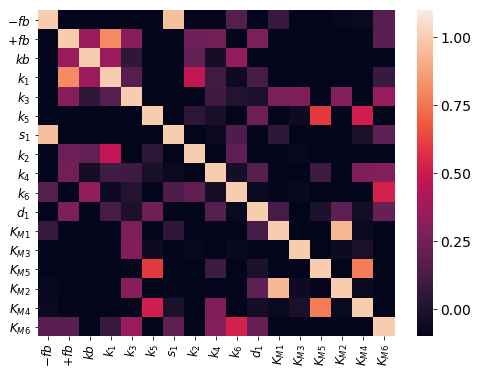

In [41]:
plotting.plt_corr(labelnames, df_top_params)
# plotting.plt_corr(labelnames, df_top_params, save_fig=model_folder+sim_id+'corr')

# M2b

##  191004_kb_M2b_hog1.py

**Notes** 

### Inputs

In [8]:
folder = 'C:/Users/sksuzuki/Desktop/killdevil/runs_for_paper/191004_kb_M2b_hog1/'

diff = np.asarray(maximums)-np.asarray(minimums)
dims = (diff, minimums)


M2b_fxns = model.Model(model.M2b, model.simulate_t100a_experiment_M2a, model.simulate_nopos_experiment_M2a)

model_folder = 'M2b/'
sim_id = 'M2b_f-hog1_'

### Gather simulated data

In [9]:
idx_top_M2b_hog1, top_params_M2b_hog1, top, plt_top, new_params, params_from_file, mse_M2b_hog1, last_mses_M2b_hog1 = model_supp.gather_simulated_data(folder, gen, runs, 0.01)
df_top_params = pd.DataFrame(top_params_M2b_hog1)
df_top_params.columns = labelnames
df_top_params_log = df_top_params.apply(np.log10)
df_top_params_log_M_M2b_hog1 = df_top_params_log.melt(var_name='param', value_name='vals')

Number of runs collected: 2000
Best MSE: 973.5511899287906
Mean MSE of top 5%: 1232.7462714919893


### Plot

In [10]:
select_top_M2b_hog1 = top_params_M2b_hog1.copy()
# select_top_M2b_hog1 = np.concatenate((select_top_M2b_hog1[1:8], select_top_M2b_hog1[10:11]))
# select_top_M2b_hog1 = select_top_M2b_hog1[:4]

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1000.
  warnings.warn(msg, RuntimeWarning)


<Figure size 720x576 with 0 Axes>

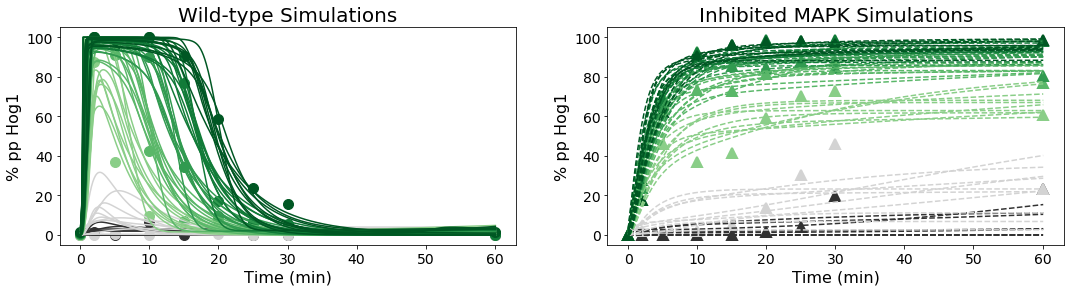

In [219]:
plotting.plt_param_behaviors(M2b_fxns, select_top_M2b_hog1, 10, params_constants, initials,  doses, time, 2, mapk_wt_data, mapk_t100a_data, mapk_time)
# plotting.plt_param_behaviors(M2b_fxns, select_top_M2b_hog1, 10, params_constants, initials,  doses, time, 2, mapk_wt_data, mapk_t100a_data, mapk_time, save_fig=model_folder+sim_id+'hog1')
# plt.savefig("C:/Users/sksuzuki/Documents/Research/figures/simulations/hog1.png",dpi=150,bbox_inches='tight')

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1000.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


<Figure size 720x576 with 0 Axes>

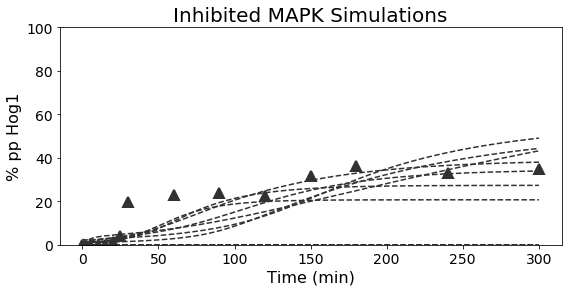

In [172]:
mapk_time_t100a_long = [0, 2, 5, 10, 15, 20, 25, 30, 60, 90, 120, 150, 180, 240, 300]

plotting.plt_t100a_long(M2b_fxns, select_top_M2b_hog1, 10, params_constants, initials, mapk_data_t100a_long[0], mapk_time_t100a_long, save_fig=model_folder+sim_id+'t100a_long')

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1000.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


<Figure size 720x576 with 0 Axes>

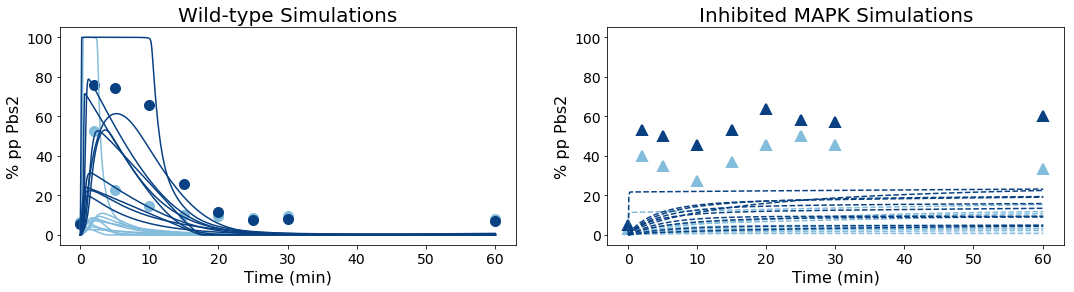

In [173]:
plotting.plt_param_behaviors(M2b_fxns, select_top_M2b_hog1, 10, params_constants, initials,  map2k_doses, time, 1, map2k_wt_data, map2k_t100a_data, mapk_time, save_fig=model_folder+sim_id+'pbs2')

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1000.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


<Figure size 720x576 with 0 Axes>

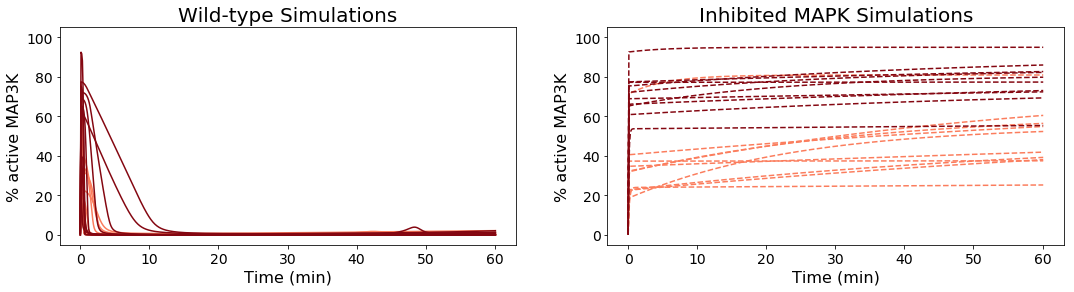

In [174]:
plotting.plt_param_behaviors(M2b_fxns, select_top_M2b_hog1, 10, params_constants, initials,  map2k_doses, time, 0, save_fig=model_folder+sim_id+'MAP3K')

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1000.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


<Figure size 720x576 with 0 Axes>

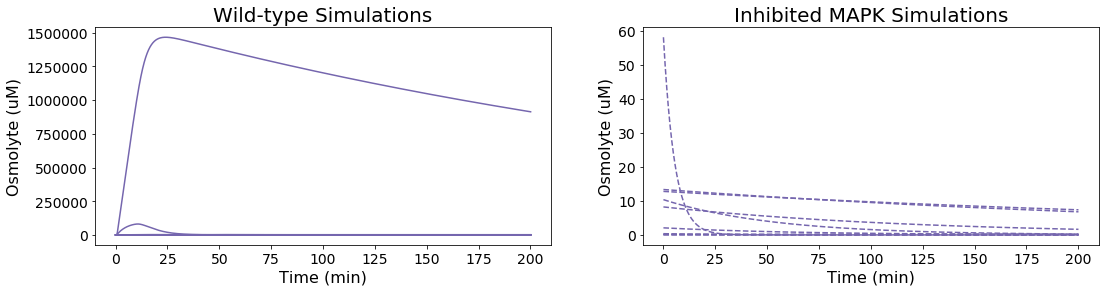

In [175]:
plotting.plt_param_behaviors(M2b_fxns, select_top_M2b_hog1, 10, params_constants, initials,  [350000], time, 3, save_fig=model_folder+sim_id+'Osmolytes')

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1000.
  warnings.warn(msg, RuntimeWarning)


<Figure size 720x576 with 0 Axes>

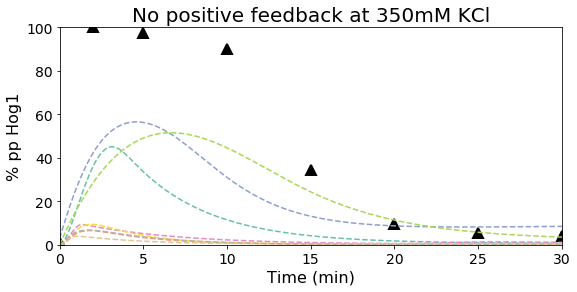

In [240]:
plotting.plt_nopos(M2b_fxns, select_top_M2b_hog1, 10, params_constants, initials, mapk_wt_data[4], mapk_time, 350000, save_fig='')

In [11]:
plotting.plt_ramp_behaviors(M2b_fxns, select_top_M2b_hog1, 10, params_constants, initials, time, 2, hog1_ramp_data, mapk_ramp_time)
# plotting.plt_ramp_behaviors(M2b_fxns, select_top_M2b_hog1, 10, params_constants, initials, time, 2, hog1_ramp_data, mapk_ramp_time, save_fig=model_folder+sim_id+'ramp')

NameError: name 'params_constants' is not defined

In [308]:
pops = {'responder' : [], 'non-responder' : []}
for params in select_top_M2b_hog1:
    ss_data = model.run_ss(M2b_fxns.m, initials, params_constants, params)
    data = model.simulate_wt_experiment(M2b_fxns.m, ss_data, params_constants, 0, params, time, run_type=['ramp'])
    active = data[:,2]/params_constants[2]*100
    second_resp = active[250:601]
    if second_resp[second_resp>15].any():
        pops['responder'].append(params)
    else:
        pops['non-responder'].append(params)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1000.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1000.
  warnings.warn(msg, RuntimeWarning)


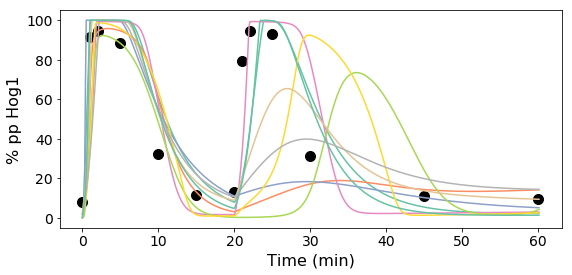

In [309]:
plotting.plt_ramp_behaviors(M2b_fxns, pops['responder'], 20, params_constants, initials, time, 2, hog1_ramp_data, mapk_ramp_time)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1000.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


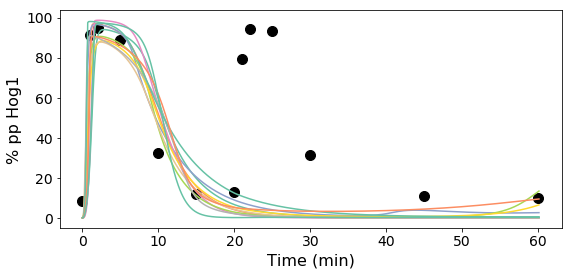

In [310]:
plotting.plt_ramp_behaviors(M2b_fxns, pops['non-responder'], 20, params_constants, initials, time, 2, hog1_ramp_data, mapk_ramp_time)

In [315]:
df_top_params_resp = pd.DataFrame(pops['responder'])
df_top_params.columns = labelnames
df_top_params_log = df_top_params_resp.apply(np.log10)
df_top_params_log_M2b_resp = df_top_params_log.melt(var_name='param', value_name='vals')

df_top_params_nonresp = pd.DataFrame(pops['non-responder'])
df_top_params.columns = labelnames
df_top_params_log = df_top_params_nonresp.apply(np.log10)
df_top_params_log_M2b_nonresp = df_top_params_log.melt(var_name='param', value_name='vals')

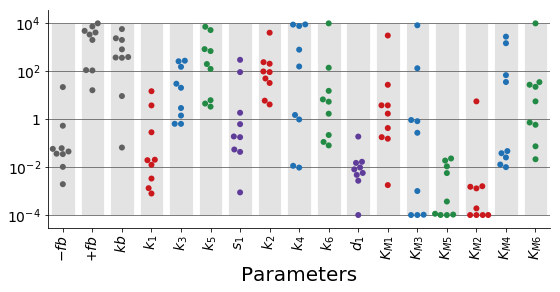

In [314]:
plotting.plt_param_ranges(labelnames, 'M2a', dims, df_top_params_log_M2b_resp)

$K_{M6}$  $k_6$       0.999887
$k_6$     $K_{M6}$    0.999887
          $K_{M2}$    0.999905
$K_{M2}$  $k_6$       0.999905
          $K_{M1}$    0.999964
$K_{M1}$  $K_{M2}$    0.999964
$K_{M6}$  $K_{M1}$    0.999973
$K_{M1}$  $K_{M6}$    0.999973
$K_{M6}$  $K_{M2}$    0.999992
$K_{M2}$  $K_{M6}$    0.999992
dtype: float64


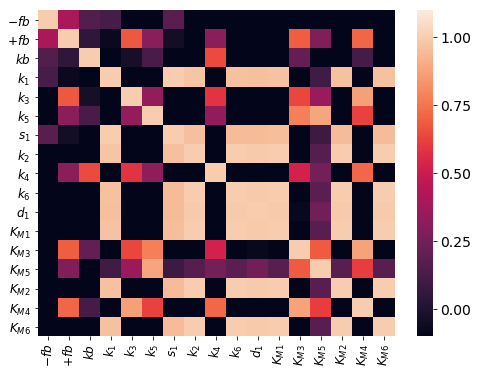

In [316]:
plotting.plt_corr(labelnames, df_top_params_resp)

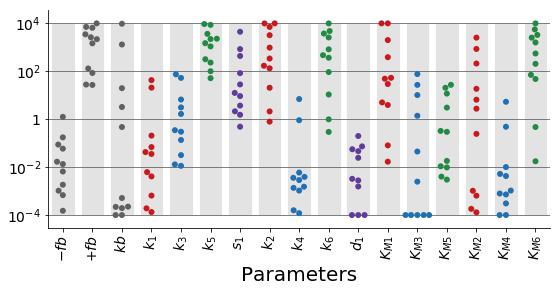

In [313]:
plotting.plt_param_ranges(labelnames, 'M2a', dims, df_top_params_log_M2b_nonresp)

$+ fb$    $- fb$      0.707757
$- fb$    $+ fb$      0.707757
$kb$      $k_3$       0.776757
$k_3$     $kb$        0.776757
$s_1$     $k_6$       0.792993
$k_6$     $s_1$       0.792993
$d_1$     $- fb$      0.867604
$- fb$    $d_1$       0.867604
$K_{M2}$  $k_4$       0.929608
$k_4$     $K_{M2}$    0.929608
dtype: float64


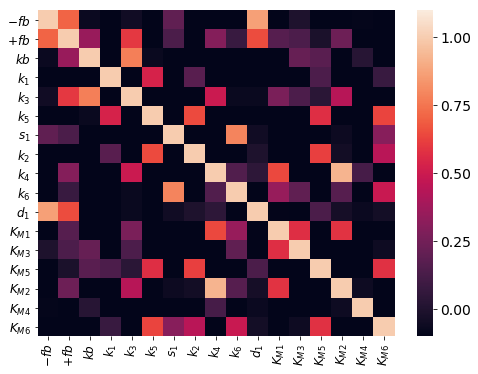

In [317]:
plotting.plt_corr(labelnames, df_top_params_nonresp)

In [319]:
from scipy.stats import ttest_ind
ttest = ttest_ind(df_top_params_resp, df_top_params_nonresp, axis=0)
print(ttest)

# lowest and only significant p value: k4 - 0.03105391 

Ttest_indResult(statistic=array([ 1.08769984,  0.32695387,  0.31655411, -0.76900194,  1.96656484,
       -0.7895247 , -1.09950698, -1.65311967,  2.33923698, -0.65818285,
       -0.33703671, -1.24252818,  1.12006708, -1.7604315 , -1.26817796,
        1.6361553 , -0.72243593]), pvalue=array([0.29107816, 0.74747422, 0.75522368, 0.45186532, 0.06484626,
       0.44008242, 0.28603561, 0.1156412 , 0.03105391, 0.5187509 ,
       0.73998725, 0.22998605, 0.2774083 , 0.09531575, 0.22089251,
       0.11917193, 0.4793083 ]))


- separate out into responders and non-responders, 
- plot different parameters (overlay parameters while plotting)
- PCA?
- correlation matrix between them? <-

<Figure size 720x576 with 0 Axes>

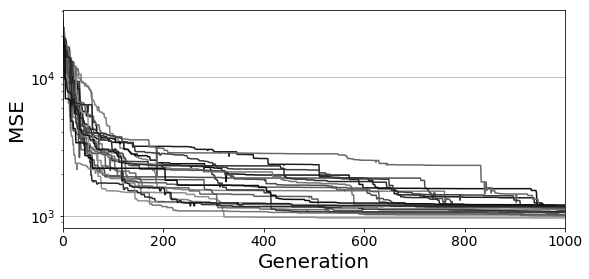

In [179]:
plotting.plt_mses_gen(gen,mse_M2b_hog1, idx_top_M2b_hog1, save_fig=model_folder+sim_id+'mses')

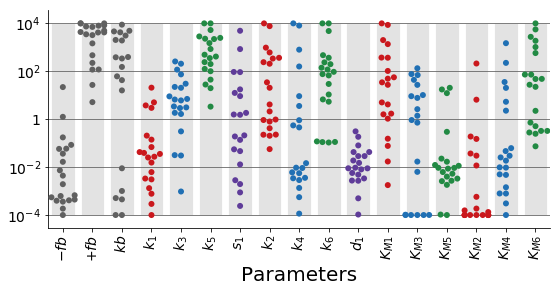

In [181]:
plotting.plt_param_ranges(labelnames, 'M2a', dims, df_top_params_log_M_M2b_hog1, save_fig=model_folder+sim_id+'params')

In [234]:
mses_M2b_hog1 = model_supp.get_mse_stats(M2b_fxns, top_params_M2b_hog1, params_constants, initials, ptpD=False)
mses_M2b_hog1.head()

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1000.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


0          1           2          3          4          5   \
0  4.741137  94.034746  166.363081  73.914368  13.411795  27.057157   
1  4.060375  38.721927  256.320908  54.554802  10.774230  15.128728   
2  5.474841  18.034047   66.191794  22.175812  10.118276  16.216001   
3  7.916145  27.629711  178.480693  47.003612   8.975486   8.791322   
4  5.445563   0.518994   87.588700  22.489697  11.954608  41.118245   

          6           7           8           9          10         11  \
0  15.254183   93.368921  136.627953   88.343677  78.264061  56.601528   
1  46.733443   56.790622  139.840476   99.855453  37.531449  55.017368   
2  32.211075  441.706265  154.906286  104.418565  84.837073  36.038335   
3  64.450590   92.888080  130.123370   87.400734  38.161973  76.837078   
4  28.776462  441.704628  200.086956  140.492074  64.843395  28.691078   

           12          13          14           15           16           17  \
0   45.172814   80.395077  375.362901   293.740293   661.125589   983.229486   
1   73.841474  156.924971  326.068036   375.148313  1300.898618  1559.230277   
2   15.053921   61.806581  380.110156   884.183751  1240.556454  2090.854801   
3  106.548324  231.388382  311.634977   257.750409  1018.565282  1464.213116   
4   38.489976   42.790937  417.221655  1138.414751  1370.158079  2498.152167   

            18  
0   648.416885  
1  2132.556009  
2  1925.768002  
3  1692.723936  
4  1703.817172

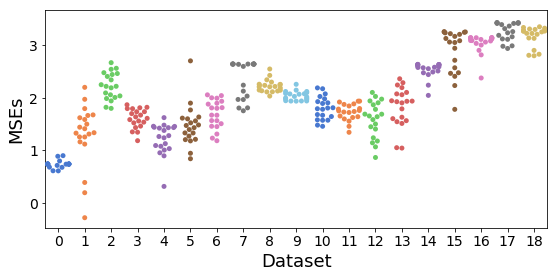

In [235]:
plotting.plt_mses_swarm(mses_M2b_hog1, save_fig='')

5923.563221534631


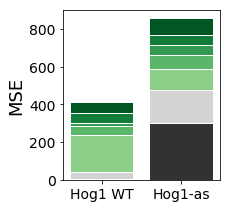

In [236]:
plotting.plt_mses(mses_M2b_hog1, (1,1, 0, 0, 0,0), size=(3,3), ptpD=False ,save_fig=model_folder+sim_id+'fit_mses')

5923.563221534631


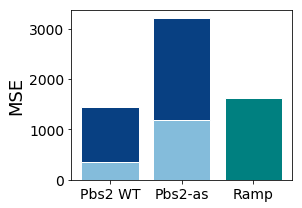

In [237]:
plotting.plt_mses(mses_M2b_hog1, (0,0, 1, 1, 1, 1), size=(4,3), ptpD=False ,save_fig=model_folder+sim_id+'predicted_mses')

$K_{M4}$  $k_3$       0.784701
$k_3$     $K_{M4}$    0.784701
$K_{M3}$  $k_3$       0.800286
$k_3$     $K_{M3}$    0.800286
          $k_4$       0.890703
$k_4$     $k_3$       0.890703
$k_6$     $K_{M6}$    0.940430
$K_{M6}$  $k_6$       0.940430
$K_{M2}$  $s_1$       0.984597
$s_1$     $K_{M2}$    0.984597
dtype: float64


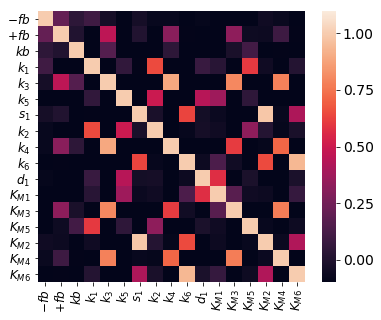

In [186]:
plotting.plt_corr(labelnames, df_top_params, save_fig=model_folder+sim_id+'corr')

### Save data

In [143]:
# save_sim_data(select_top_M4, doses, 2, path='C:/Users/sksuzuki/Documents/Research/figures/paper1/unsorted/', sim_name='M4_t100a', t100a=True)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [151]:
# save_sim_data(select_top_M4, doses, 2, path='C:/Users/sksuzuki/Documents/Research/figures/paper1/unsorted/', sim_name='M4_ramp', ramp=True)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


##  191205_kb_M2b.py

**Notes** 

- saved as the wrong date - 191010 should be 191014

### Inputs

In [20]:
# folder = 'C:/Users/sksuzuki/Desktop/killdevil/runs_for_paper/191010_kb_M2b/' # wrong model!
folder = 'C:/Users/sksuzuki/Desktop/killdevil/runs_for_paper/191205_kb_M2b/'


M2b_fxns = model.Model(model.M2b_kb, model.simulate_t100a_experiment_M2a_kb, model.simulate_nopos_experiment_M2a_kb)

model_folder = 'M2b/'
sim_id = 'M2b_f-all_'

### Gather simulated data

In [21]:
idx_top_M2b_all, top_params_M2b_all, top, plt_top, new_params, params_from_file, mse_M2b_all, last_mses_M2b_all = model_supp.gather_simulated_data(folder, 1000, runs, 0.1)
df_top_params = pd.DataFrame(top_params_M2b_all)
df_top_params.columns = labelnames
df_top_params_log = df_top_params.apply(np.log10)
df_top_params_log_M_M2b_all = df_top_params_log.melt(var_name='param', value_name='vals')

Number of runs collected: 2000
Best MSE: 1857.0865576680335
Mean MSE of top 5%: 2973.2963454650685


### Plot

In [22]:
select_top_M2b_all = top_params_M2b_all.copy()
# select_top_M2b_all_r = np.concatenate((select_top_M2b_all[2:4], select_top_M2b_all[5:6]))
# select_top_M2b_all_nr = np.concatenate((select_top_M2b_all[:2], select_top_M2b_all[4:4], select_top_M2b_all[6:10]))
# select_top_M2b_all_nr = select_top_M2b_all[:2]

<Figure size 720x576 with 0 Axes>

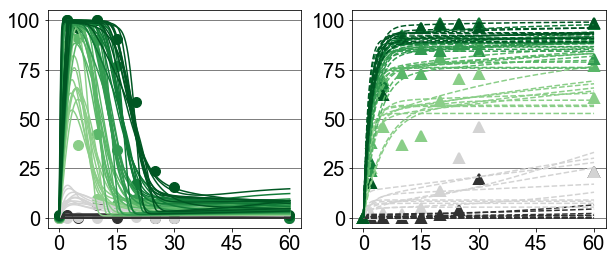

In [36]:
plotting.plt_param_behaviors(M2b_fxns, select_top_M2b_all, 10, params_constants, initials,  doses, time, 2, mapk_wt_data, mapk_t100a_data, mapk_time, ss=True)
# plotting.plt_param_behaviors(M2b_fxns, select_top_M2b_all, 10, params_constants, initials,  doses, time, 2, mapk_wt_data, mapk_t100a_data, mapk_time, save_fig=model_folder+sim_id+'hog1')


<Figure size 720x576 with 0 Axes>

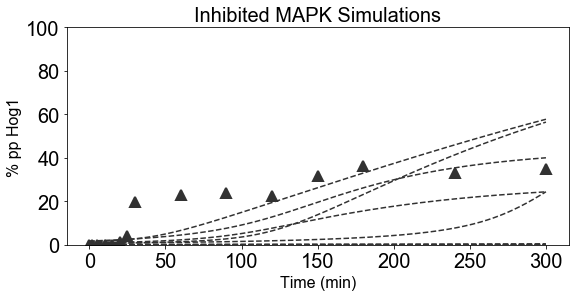

In [39]:
mapk_time_t100a_long = [0, 2, 5, 10, 15, 20, 25, 30, 60, 90, 120, 150, 180, 240, 300]
plotting.plt_t100a_long(M2b_fxns, select_top_M2b_all, 10, params_constants, initials, mapk_data_t100a_long[0], mapk_time_t100a_long)
# plotting.plt_t100a_long(M2b_fxns, select_top_M2b_all, 10, params_constants, initials, mapk_data_t100a_long[0], mapk_time_t100a_long, save_fig=model_folder+sim_id+'t100a_long')

<Figure size 720x576 with 0 Axes>

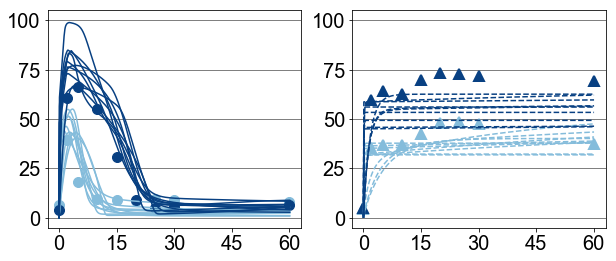

In [38]:
plotting.plt_param_behaviors(M2b_fxns, select_top_M2b_all, 10, params_constants, initials,  map2k_doses, time, 1, map2k_wt_data, map2k_t100a_data, mapk_time, ss=True)
# plotting.plt_param_behaviors(M2b_fxns, select_top_M2b_all, 10, params_constants, initials,  map2k_doses, time, 1, map2k_wt_data, map2k_t100a_data, mapk_time, save_fig=model_folder+sim_id+'pbs2')

<Figure size 720x576 with 0 Axes>

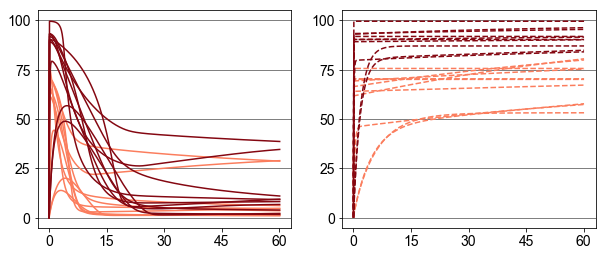

In [40]:
plotting.plt_param_behaviors(M2b_fxns, select_top_M2b_all, 10, params_constants, initials,  map2k_doses, time, 0, ss=True)
# plotting.plt_param_behaviors(M2b_fxns, select_top_M2b_all, 10, params_constants, initials,  map2k_doses, time, 0, save_fig=model_folder+sim_id+'MAP3K')

<Figure size 720x576 with 0 Axes>

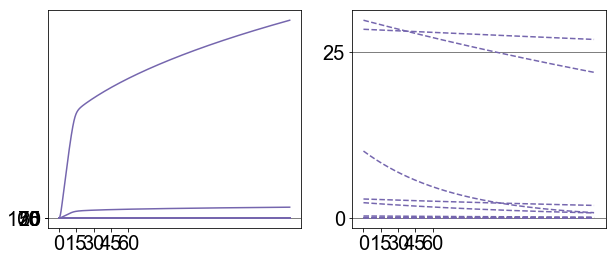

In [41]:
plotting.plt_param_behaviors(M2b_fxns, select_top_M2b_all, 10, params_constants, initials,  [350000], time, 3, ss=True)
# plotting.plt_param_behaviors(M2b_fxns, select_top_M2b_all, 10, params_constants, initials,  [350000], time, 3, save_fig=model_folder+sim_id+'Osmolytes')

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


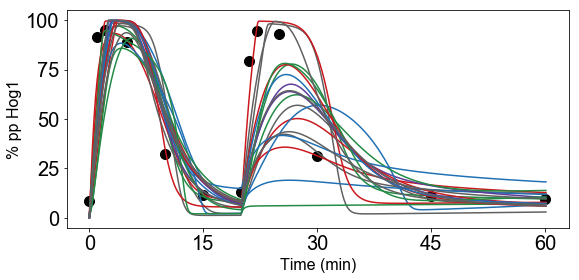

In [35]:
plotting.plt_ramp_behaviors(M2b_fxns, select_top_M2b_all, 20, params_constants, initials, time, 2, ss = True, hog1_ramp_data=hog1_ramp_data, mapk_ramp_time=mapk_ramp_time)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1000.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


<Figure size 720x576 with 0 Axes>

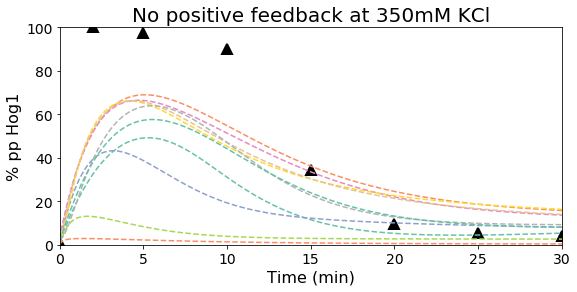

In [393]:
plotting.plt_nopos(M2b_fxns, select_top_M2b_all, 10, params_constants, initials, mapk_wt_data[4], mapk_time, 350000, save_fig='')

<Figure size 720x576 with 0 Axes>

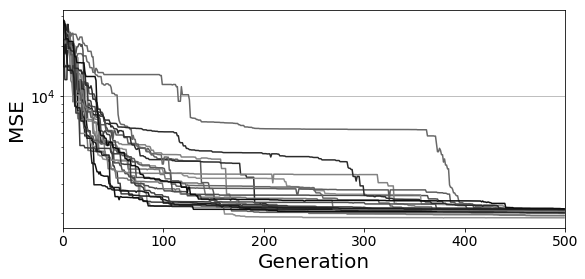

In [55]:
# plotting.plt_mses_gen(gen,mse_M2b_all, idx_top_M2b_all, save_fig=model_folder+sim_id+'mses')
plotting.plt_mses_gen(gen,mse_M2b_all, idx_top_M2b_all)

KeyError: 'the label [0] is not in the [index]'

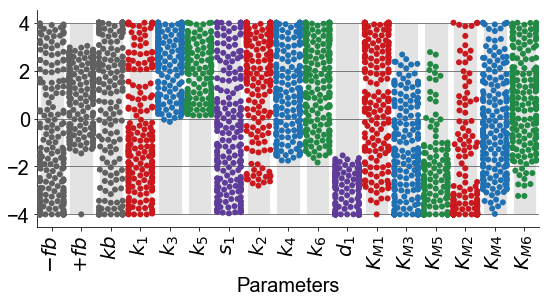

In [45]:
plotting.plt_param_ranges(labelnames, 'M2a', dims, df_top_params_log_M_M2b_all)
# plotting.plt_param_ranges(labelnames, 'M2a', dims, df_top_params_log_M_M2b_all, save_fig=model_folder+sim_id+'params')

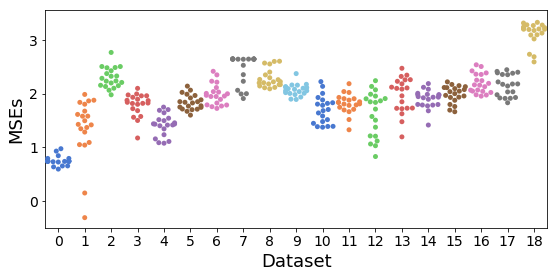

In [155]:
plotting.plt_mses_swarm(mses_M2b_all, save_fig='')

1904.3413689225868


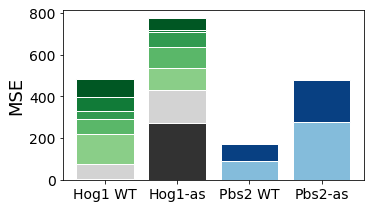

In [165]:
plotting.plt_mses(mses_M2b_all[:2],(1,1, 1, 1, 0,0), size=(5,3), ptpD=False)

1967.6834383865514


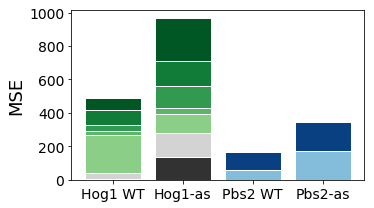

In [166]:
plotting.plt_mses(mses_M2b_all[2:4], (1,1, 1, 1, 0,0), size=(5,3), ptpD=False)
# plotting.plt_mses(mses_M2b_all, (1,1, 1, 1, 0,0), size=(5,3), ptpD=False ,save_fig=model_folder+sim_id+'fit_mses')

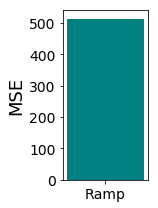

In [136]:
plotting.plt_mses(mses_M2b_all[2:4], (0,0, 0, 0, 1, 1), size=(2,3), ptpD=False)
# plotting.plt_mses(mses_M2b_all, (0,0, 0, 0, 1, 1), size=(2,3), ptpD=False ,save_fig=model_folder+sim_id+'predicted_mses')

$+ fb$    $k_3$       0.576308
$k_3$     $+ fb$      0.576308
$k_1$     $K_{M1}$    0.599241
$K_{M1}$  $k_1$       0.599241
$K_{M6}$  $k_6$       0.617703
$k_6$     $K_{M6}$    0.617703
$K_{M2}$  $k_4$       0.853115
$k_4$     $K_{M2}$    0.853115
$s_1$     $- fb$      0.994196
$- fb$    $s_1$       0.994196
dtype: float64


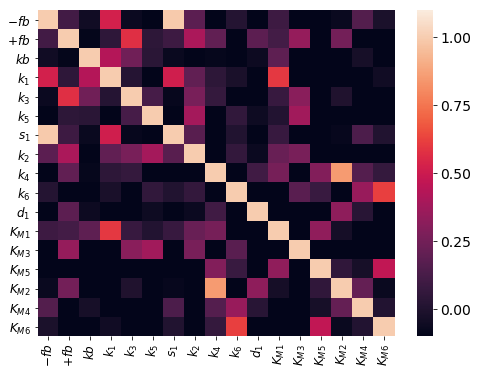

In [246]:
plotting.plt_corr(labelnames, df_top_params, save_fig=model_folder+sim_id+'corr')

#### Comparing subsets of parameters

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1000.
  warnings.warn(msg, RuntimeWarning)


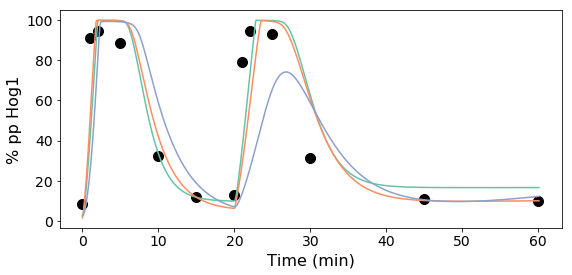

In [188]:
plotting.plt_ramp_behaviors(M2b_fxns, select_top_M2b_all_r, 10, params_constants, initials, time, 2, hog1_ramp_data, mapk_ramp_time)
# plotting.plt_ramp_behaviors(M2b_fxns, select_top_M2b_all, 10, params_constants, initials, time, 2, hog1_ramp_data, mapk_ramp_time, save_fig=model_folder+sim_id+'ramp')

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1000.
  warnings.warn(msg, RuntimeWarning)


<Figure size 720x576 with 0 Axes>

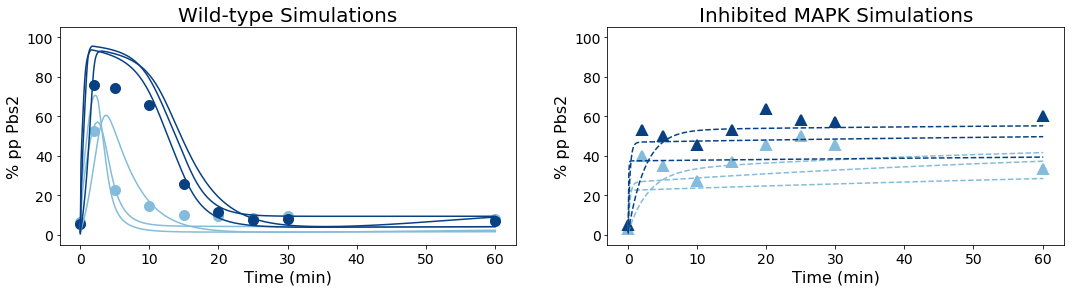

In [185]:
plotting.plt_param_behaviors(M2b_fxns, select_top_M2b_all_r, 10, params_constants, initials,  map2k_doses, time, 1, map2k_wt_data, map2k_t100a_data, mapk_time)

In [31]:
plotting.plt_param_behaviors(M2b_fxns, select_top_M2b_all_nr, 10, params_constants, initials,   [150000], time, 2, [mapk_wt_data[2]], [mapk_t100a_data[2]], mapk_time)
# plotting.plt_param_behaviors(M2b_fxns, select_top_M2b_all, 10, params_constants, initials,  doses, time, 2, mapk_wt_data, mapk_t100a_data, mapk_time, save_fig=model_folder+sim_id+'hog1')


NameError: name 'select_top_M2b_all_nr' is not defined

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1000.
  warnings.warn(msg, RuntimeWarning)


<Figure size 720x576 with 0 Axes>

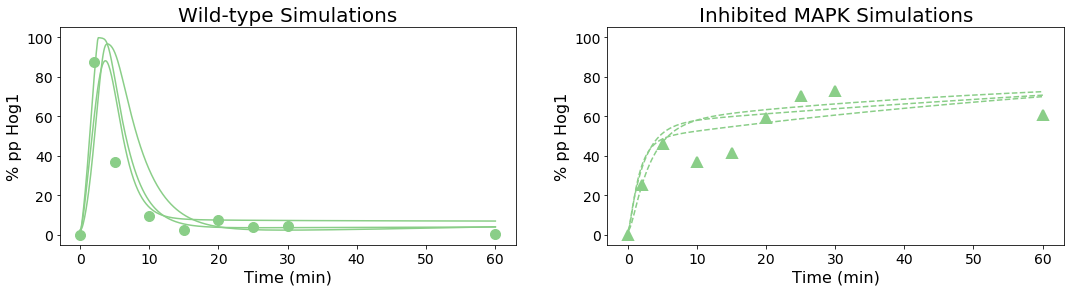

In [190]:
plotting.plt_param_behaviors(M2b_fxns, select_top_M2b_all_r, 10, params_constants, initials,  [150000], time, 2, [mapk_wt_data[2]], [mapk_t100a_data[2]], mapk_time)
# plotting.plt_param_behaviors(M2b_fxns, select_top_M2b_all, 10, params_constants, initials,  doses, time, 2, mapk_wt_data, mapk_t100a_data, mapk_time, save_fig=model_folder+sim_id+'hog1')


C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


<Figure size 720x576 with 0 Axes>

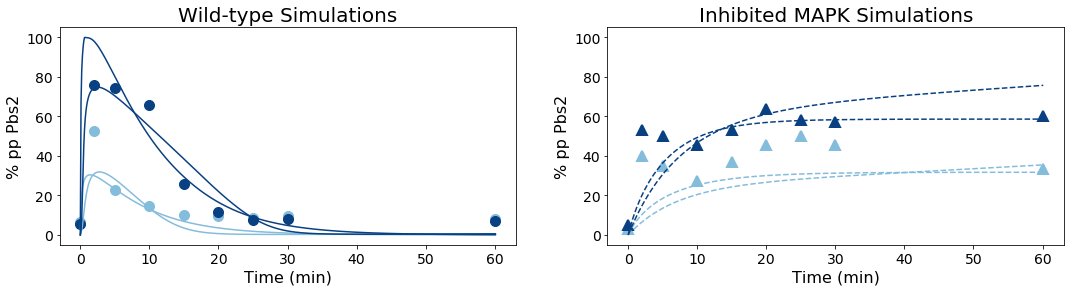

In [184]:
plotting.plt_param_behaviors(M2b_fxns, select_top_M2b_all_nr, 10, params_constants, initials,  map2k_doses, time, 1, map2k_wt_data, map2k_t100a_data, mapk_time)

In [371]:
pops = {'responder' : [], 'non-responder' : []}
for params in select_top_M2b_all[:10]:
    ss_data = model.run_ss(M2b_fxns.m, initials, params_constants, params)
    data = model.simulate_wt_experiment(M2b_fxns.m, ss_data, params_constants, 0, params, time, run_type=['ramp'])
    active = data[:,2]/params_constants[2]*100
    second_resp = active[201:301]
    if second_resp[second_resp>40].any():
        pops['responder'].append(params)
    else:
        pops['non-responder'].append(params)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1000.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1000.
  warnings.warn(msg, RuntimeWarning)


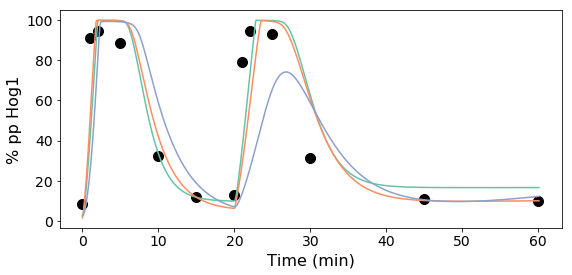

In [373]:
plotting.plt_ramp_behaviors(M2b_fxns, pops['responder'], 20, params_constants, initials, time, 2, hog1_ramp_data, mapk_ramp_time)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1000.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


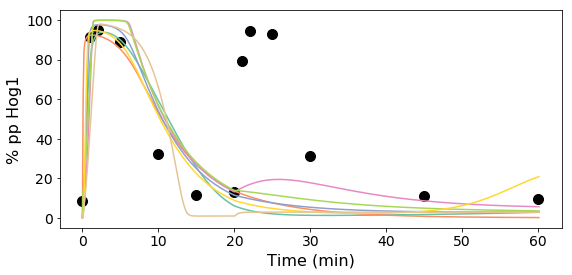

In [374]:
plotting.plt_ramp_behaviors(M2b_fxns, pops['non-responder'], 20, params_constants, initials, time, 2, hog1_ramp_data, mapk_ramp_time)

In [363]:
df_top_params_resp = pd.DataFrame(pops['responder'])
df_top_params.columns = labelnames
df_top_params_log = df_top_params_resp.apply(np.log10)
df_top_params_log_M2b_resp = df_top_params_log.melt(var_name='param', value_name='vals')

df_top_params_nonresp = pd.DataFrame(pops['non-responder'])
df_top_params.columns = labelnames
df_top_params_log = df_top_params_nonresp.apply(np.log10)
df_top_params_log_M2b_nonresp = df_top_params_log.melt(var_name='param', value_name='vals')

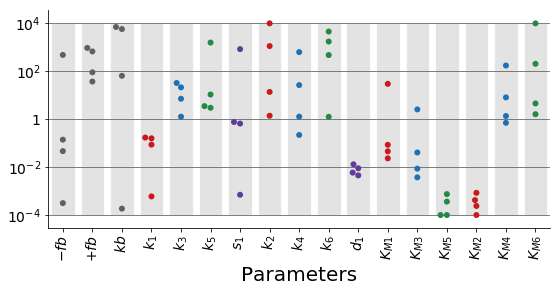

In [364]:
plotting.plt_param_ranges(labelnames, 'M2a', dims, df_top_params_log_M2b_resp)

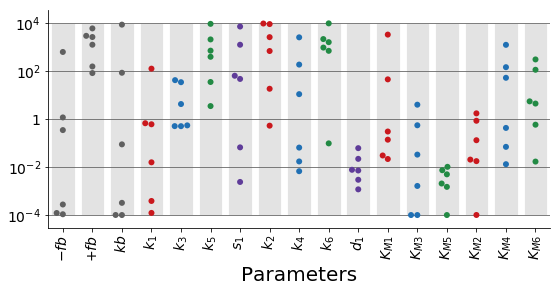

In [365]:
plotting.plt_param_ranges(labelnames, 'M2a', dims, df_top_params_log_M2b_nonresp)

In [366]:
from scipy.stats import ttest_ind
ttest = ttest_ind(df_top_params_resp, df_top_params_nonresp, axis=0)
print(ttest)

# lowest and only significant p value: kM5 - 0.04342801 (with top 20, threshold = 15)

Ttest_indResult(statistic=array([ 0.11047196, -1.50960468,  0.78580381, -0.80585264,  0.18297711,
       -0.8987407 , -0.82296924, -0.27462441, -0.53847097, -0.39726073,
       -0.75499398, -0.80207713, -0.10458094, -2.03648206, -1.27624389,
       -0.75940545,  1.26397565]), pvalue=array([0.91475622, 0.16958345, 0.45462469, 0.44361968, 0.85936814,
       0.39503559, 0.43436935, 0.79056343, 0.60490653, 0.7015636 ,
       0.47189199, 0.4456781 , 0.9192828 , 0.07608812, 0.23767127,
       0.46939329, 0.24182264]))


$- fb$    $K_{M3}$    0.999914
$K_{M3}$  $- fb$      0.999914
$k_5$     $K_{M3}$    0.999963
$K_{M3}$  $k_5$       0.999963
$s_1$     $k_5$       0.999986
$k_5$     $s_1$       0.999986
          $- fb$      0.999989
$- fb$    $k_5$       0.999989
          $s_1$       1.000000
$s_1$     $- fb$      1.000000
dtype: float64


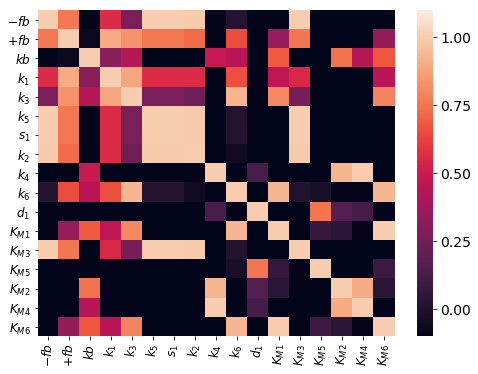

In [367]:
plotting.plt_corr(labelnames, df_top_params_resp)

$K_{M2}$  $d_1$       0.981772
$d_1$     $K_{M2}$    0.981772
$K_{M1}$  $K_{M3}$    0.990009
$K_{M3}$  $K_{M1}$    0.990009
$k_1$     $K_{M3}$    0.990202
$K_{M3}$  $k_1$       0.990202
$K_{M4}$  $- fb$      0.993293
$- fb$    $K_{M4}$    0.993293
$K_{M1}$  $k_1$       0.999946
$k_1$     $K_{M1}$    0.999946
dtype: float64


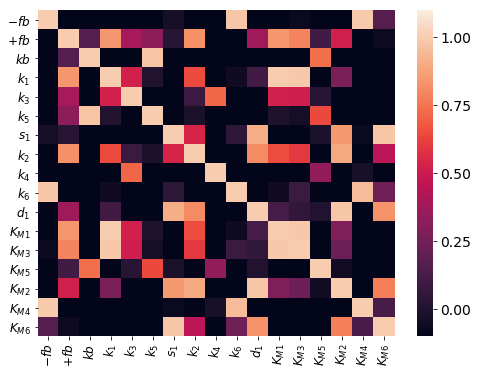

In [368]:
plotting.plt_corr(labelnames, df_top_params_nonresp)

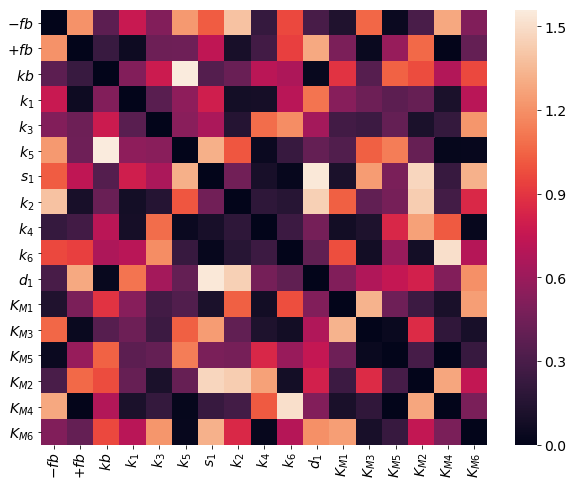

In [369]:
corr_diff = abs(df_top_params_resp.corr() - df_top_params_nonresp.corr())
sns.heatmap(corr_diff)

In [370]:
s = corr_diff.unstack()
so = s.sort_values(kind="quicksort")
print(so[-20:])

$k_5$     $s_1$       1.317134
$s_1$     $k_5$       1.317134
$K_{M6}$  $s_1$       1.322101
$s_1$     $K_{M6}$    1.322101
$K_{M1}$  $K_{M3}$    1.329320
$K_{M3}$  $K_{M1}$    1.329320
$k_2$     $- fb$      1.389577
$- fb$    $k_2$       1.389577
$k_2$     $K_{M2}$    1.430663
$K_{M2}$  $k_2$       1.430663
$k_2$     $d_1$       1.445385
$d_1$     $k_2$       1.445385
$s_1$     $K_{M2}$    1.470337
$K_{M2}$  $s_1$       1.470337
$K_{M4}$  $k_6$       1.507722
$k_6$     $K_{M4}$    1.507722
$d_1$     $s_1$       1.541237
$s_1$     $d_1$       1.541237
$k_5$     $kb$        1.558477
$kb$      $k_5$       1.558477
dtype: float64


In [154]:
mses_M2b_all = model_supp.get_mse_stats(M2b_fxns, top_params_M2b_all, params_constants, initials, ptpD=False)
mses_M2b_all.head()

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1000.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


0          1           2          3          4           5   \
0  5.474917  47.195875  158.239600  74.145526  32.686238   46.832766   
1  4.299962  96.682314  126.233525  66.810425  50.346717   83.128395   
2  6.948166  40.983837  236.775212  36.247319  56.069721  116.153819   
3  4.472033  31.220161  213.520161  14.874404  17.124372   58.663585   
4  3.910902  75.390237  171.178364  52.487802  34.795049  138.210710   

           6           7           8           9           10          11  \
0   66.792506  441.707534  166.026862   79.007694   67.702926   75.652224   
1  109.077310   98.568526  151.793604  131.743976  136.897472   64.452085   
2   88.476414   99.822789  147.370745  100.982034   48.094666  153.485466   
3   61.704517  170.157535  138.953628  126.096486   30.125704  109.304148   
4  261.273273  338.173304  147.208791  109.177820   63.752355   60.460646   

           12          13         14          15          16          17  \
0   13.078948   70.512880  95.602574   57.559964  228.150803  151.368637   
1   10.667466   42.137699  86.022717   99.976781  321.070594  251.034698   
2  174.560499  297.328438  25.947299  130.167421  111.576950   67.634130   
3  117.886969  221.402624  95.975794   75.277050  230.711629  279.271151   
4   16.255530   53.502720  61.386395  119.212216  143.828092  151.817778   

            18  
0  1867.292056  
1  1575.890257  
2   488.456949  
3   542.499678  
4  1594.971045

### Save data

In [143]:
# save_sim_data(select_top_M4, doses, 2, path='C:/Users/sksuzuki/Documents/Research/figures/paper1/unsorted/', sim_name='M4_t100a', t100a=True)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [151]:
# save_sim_data(select_top_M4, doses, 2, path='C:/Users/sksuzuki/Documents/Research/figures/paper1/unsorted/', sim_name='M4_ramp', ramp=True)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


# M2c

##  191004_kb_M2c_hog1.py

**Notes** 
- M4 model - mutual inhibition model, though i named the files M3. 

### Inputs

In [18]:
folder = 'C:/Users/sksuzuki/Desktop/killdevil/runs_for_paper/191004_kb_M2c_hog1/'

diff = np.asarray(maximums)-np.asarray(minimums)
dims = (diff, minimums)




# mapk_time_t100a_long = [0, 2, 5, 10, 15, 20, 25, 30, 60, 90, 120, 150, 180, 240, 300]

# labels = ['MAP3K','MAP2K','MAPK','gly', 'PTP']

M2c_fxns = model.Model(model.M2c, model.simulate_t100a_experiment_M2a, model.simulate_nopos_experiment_M2a)

model_folder = 'M2c/'
sim_id = 'M2c_f-hog1_'

### Gather simulated data

In [19]:
idx_top_M2c_hog1, top_params_M2c_hog1, top, plt_top, new_params, params_from_file, mse_M2c_hog1, last_mses_M2c_hog1 = model_supp.gather_simulated_data(folder, gen, runs, 0.1)
df_top_params = pd.DataFrame(top_params_M2c_hog1)
df_top_params.columns = labelnames
df_top_params_log = df_top_params.apply(np.log10)
df_top_params_log_M_M2c_hog1 = df_top_params_log.melt(var_name='param', value_name='vals')

KeyboardInterrupt: 

### Plot

In [16]:
select_top_M2c_hog1 = top_params_M2c_hog1.copy()
# select_top_M2_all = np.concatenate((select_top_[:7], select_top_M4[8:11]))

NameError: name 'top_params_M2c_hog1' is not defined

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1000.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


<Figure size 720x576 with 0 Axes>

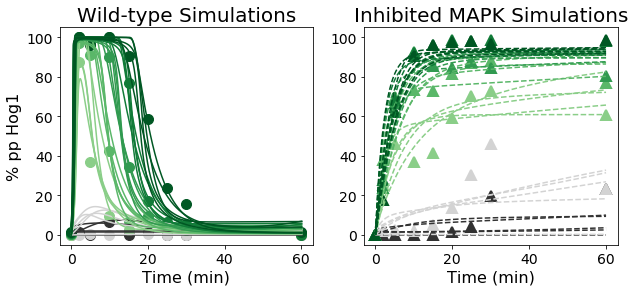

In [105]:
plotting.plt_param_behaviors(M2c_fxns, select_top_M2c_hog1, 5, params_constants, initials,  doses, time, 2, mapk_wt_data, mapk_t100a_data, mapk_time, save_fig='M3c_hog1')
# plt.savefig("C:/Users/sksuzuki/Documents/Research/figures/simulations/hog1.png",dpi=150,bbox_inches='tight')

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1000.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


<Figure size 720x576 with 0 Axes>

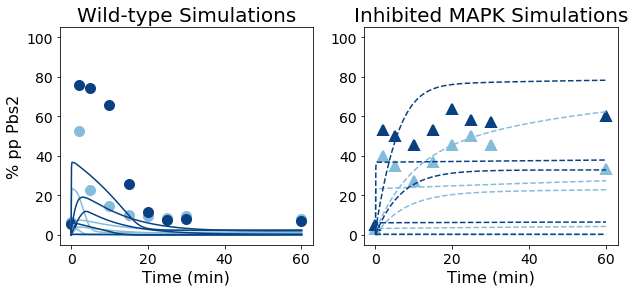

In [106]:
plotting.plt_param_behaviors(M2c_fxns, select_top_M2c_hog1, 5, params_constants, initials,  map2k_doses, time, 1, map2k_wt_data, map2k_t100a_data, mapk_time, save_fig='M3c_pbs2')

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1000.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


<Figure size 720x576 with 0 Axes>

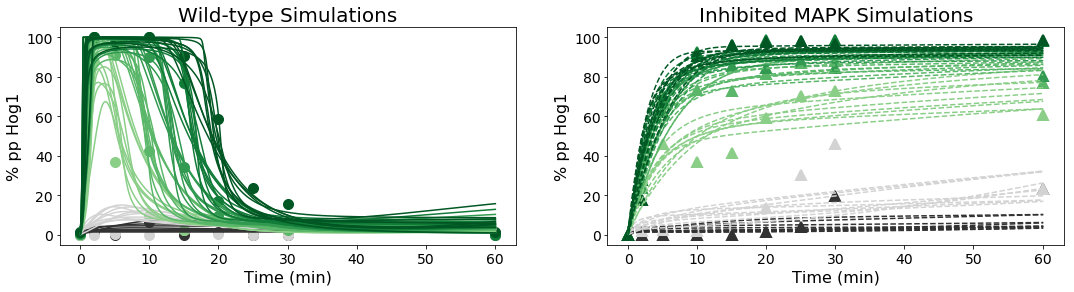

In [191]:
plotting.plt_param_behaviors(M2c_fxns, select_top_M2c_hog1, 5, params_constants, initials,  doses, time, 2, mapk_wt_data, mapk_t100a_data, mapk_time, save_fig=model_folder+sim_id+'hog1')
# plt.savefig("C:/Users/sksuzuki/Documents/Research/figures/simulations/hog1.png",dpi=150,bbox_inches='tight')

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1000.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


<Figure size 720x576 with 0 Axes>

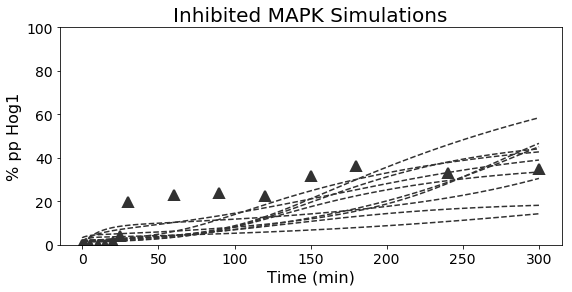

In [192]:
mapk_time_t100a_long = [0, 2, 5, 10, 15, 20, 25, 30, 60, 90, 120, 150, 180, 240, 300]

plotting.plt_t100a_long(M2c_fxns, select_top_M2c_hog1, 10, params_constants, initials, mapk_data_t100a_long[0], mapk_time_t100a_long, save_fig=model_folder+sim_id+'t100a_long')

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1000.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


<Figure size 720x576 with 0 Axes>

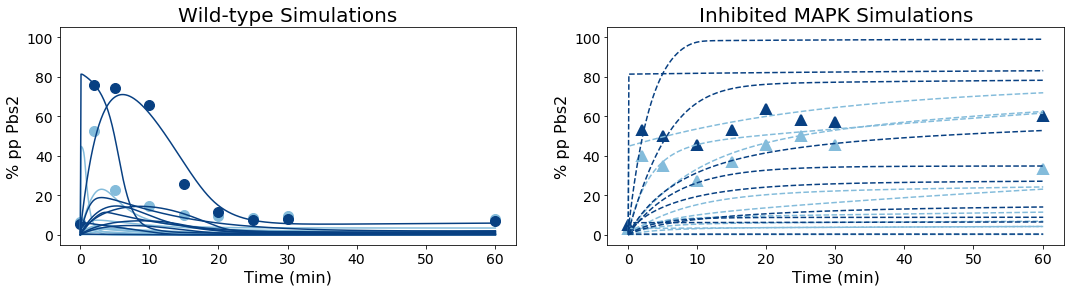

In [193]:
plotting.plt_param_behaviors(M2c_fxns, select_top_M2c_hog1, 10, params_constants, initials,  map2k_doses, time, 1, map2k_wt_data, map2k_t100a_data, mapk_time, save_fig=model_folder+sim_id+'pbs2')

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1000.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


<Figure size 720x576 with 0 Axes>

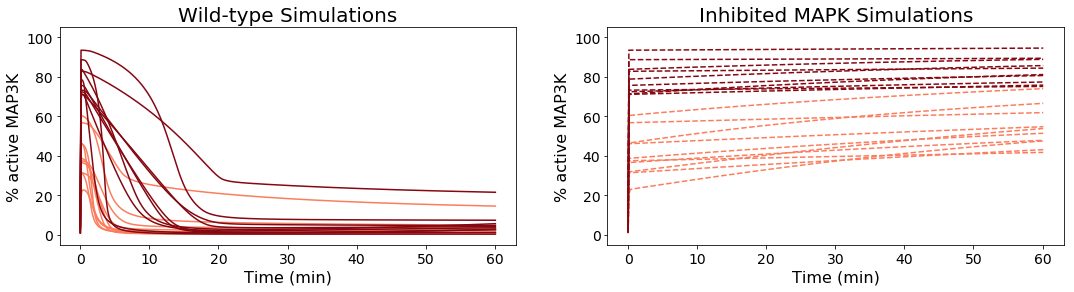

In [194]:
plotting.plt_param_behaviors(M2c_fxns, select_top_M2c_hog1, 10, params_constants, initials,  map2k_doses, time, 0, save_fig=model_folder+sim_id+'MAP3K')

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1000.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


<Figure size 720x576 with 0 Axes>

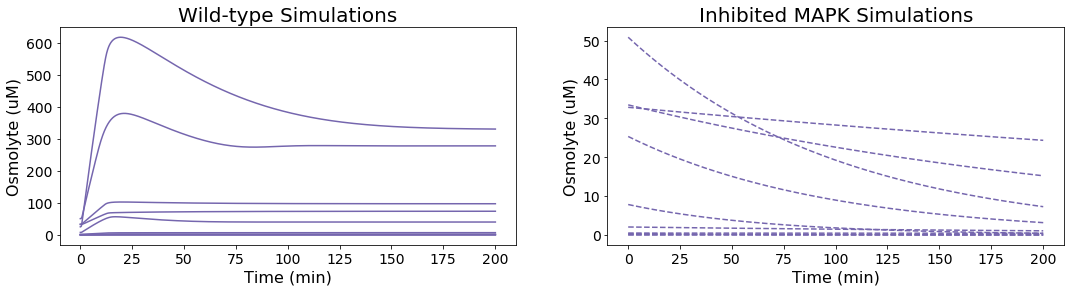

In [195]:
plotting.plt_param_behaviors(M2c_fxns, select_top_M2c_hog1, 10, params_constants, initials,  [350000], time, 3, save_fig=model_folder+sim_id+'Osmolytes')

In [15]:
plotting.plt_ramp_behaviors(M2c_fxns, select_top_M2c_hog1, 10, params_constants, initials, time, 2, hog1_ramp_data, mapk_ramp_time)
# plotting.plt_ramp_behaviors(M2c_fxns, select_top_M2c_hog1, 10, params_constants, initials, time, 2, hog1_ramp_data, mapk_ramp_time, save_fig=model_folder+sim_id+'ramp')

NameError: name 'select_top_M2c_hog1' is not defined

<Figure size 720x576 with 0 Axes>

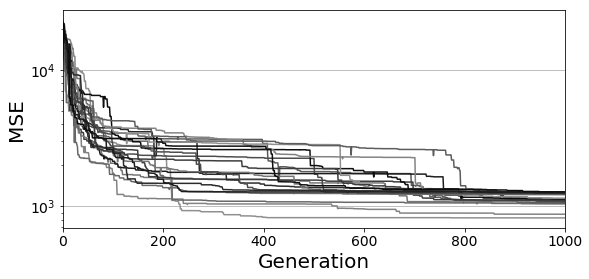

In [199]:
plotting.plt_mses_gen(gen,mse_M2c_hog1, idx_top_M2c_hog1, save_fig=model_folder+sim_id+'mses')

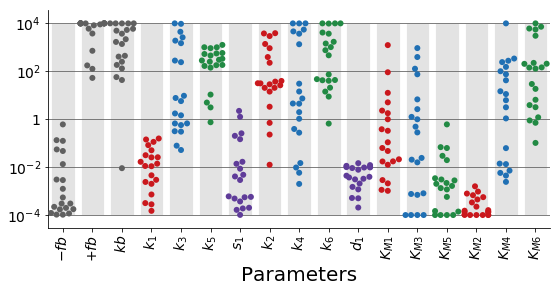

In [200]:
plotting.plt_param_ranges(labelnames, 'M2a', dims, df_top_params_log_M_M2c_hog1, save_fig=model_folder+sim_id+'params')

In [201]:
mses_M2c_hog1 = model_supp.get_mse_stats(M2c_fxns, top_params_M2c_hog1, params_constants, initials, ptpD=False)
mses_M2c_hog1.head()

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1000.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


0          1           2          3          4          5   \
0  11.508969  60.009986   82.053837  11.021983   8.038939   4.647568   
1  19.396893  48.078233   59.752409  13.573431   4.565292   6.822862   
2   5.441254  35.976841  162.960385  45.548648  25.778408  67.848802   
3   4.745791  36.327594  339.866149  48.889810  14.203478  49.727345   
4   5.720111  24.451006  109.321016  17.773275  38.530835  26.735085   

          6           7           8           9           10         11  \
0  89.084674   54.129054  117.527848  144.540318  117.923966  65.621401   
1  85.291570  103.000417  137.156330  124.897315  115.866548  79.982967   
2  64.609815   97.157506  205.788696  129.365393   44.429159  53.131941   
3  35.747450  101.109913  121.272792   93.256695   50.476289  43.964804   
4  93.676695  126.241066  166.758316   96.179181   44.984029  64.751593   

          12          13           14           15           16           17  
0  23.727401   32.560757  1087.890644   226.719432   339.190842  1589.472803  
1  46.347422   30.462730  1411.679574   494.237595   734.814108  1782.476751  
2  40.589864   63.026062   589.795862   398.904304   672.007998  1265.889887  
3  33.685916   77.278949  1661.045624  1167.141735  2141.099725   526.060222  
4  70.610165  176.068142   114.988702   189.693416  1318.117133   169.661941

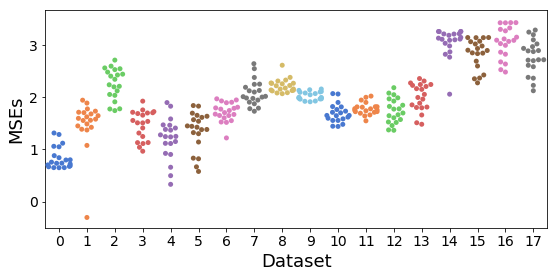

In [202]:
plotting.plt_mses_swarm(mses_M2c_hog1, save_fig='')

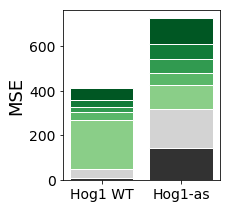

In [203]:
plotting.plt_mses(mses_M2c_hog1, (1,1, 0, 0, 0,0), size=(3,3), ptpD=False ,save_fig=model_folder+sim_id+'fit_mses')

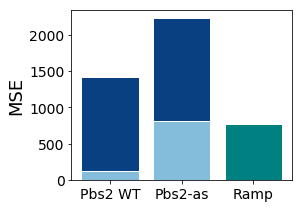

In [204]:
plotting.plt_mses(mses_M2c_hog1, (0,0, 1, 1, 1, 1), size=(4,3), ptpD=False ,save_fig=model_folder+sim_id+'predicted_mses')

$+ fb$    $k_5$       0.605463
$k_5$     $+ fb$      0.605463
$- fb$    $s_1$       0.629005
$s_1$     $- fb$      0.629005
$k_6$     $k_2$       0.792034
$k_2$     $k_6$       0.792034
          $K_{M2}$    0.814501
$K_{M2}$  $k_2$       0.814501
$k_1$     $kb$        0.827684
$kb$      $k_1$       0.827684
dtype: float64


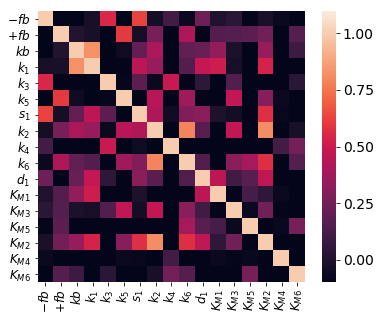

In [205]:
plotting.plt_corr(labelnames, df_top_params, save_fig=model_folder+sim_id+'corr')

### Save data

In [143]:
# save_sim_data(select_top_M4, doses, 2, path='C:/Users/sksuzuki/Documents/Research/figures/paper1/unsorted/', sim_name='M4_t100a', t100a=True)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [151]:
# save_sim_data(select_top_M4, doses, 2, path='C:/Users/sksuzuki/Documents/Research/figures/paper1/unsorted/', sim_name='M4_ramp', ramp=True)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


##  191010_kb_M2c.py

**Notes** 

### Inputs

In [46]:
# folder = 'C:/Users/sksuzuki/Desktop/killdevil/runs_for_paper/191010_kb_M2c/' #wrong model!
folder = 'C:/Users/sksuzuki/Desktop/killdevil/runs_for_paper/191205_kb_M2c/' 

M2c_fxns = model.Model(model.M2c_kb, model.simulate_t100a_experiment_M2a_kb, model.simulate_nopos_experiment_M2a_kb)

model_folder = 'M2c/'
sim_id = 'M2c_f-all_'

### Gather simulated data

In [47]:
idx_top_M2c_all, top_params_M2c_all, top, plt_top, new_params, params_from_file, mse_M2c_all, last_mses_M2c_all = model_supp.gather_simulated_data(folder, 1000, runs, 0.1)
df_top_params = pd.DataFrame(top_params_M2c_all)
df_top_params.columns = labelnames
df_top_params_log = df_top_params.apply(np.log10)
df_top_params_log_M_M2c_all = df_top_params_log.melt(var_name='param', value_name='vals')

Number of runs collected: 2357
Best MSE: 1666.0685223278435
Mean MSE of top 5%: 2386.547460380073


### Plot

No handles with labels found to put in legend.


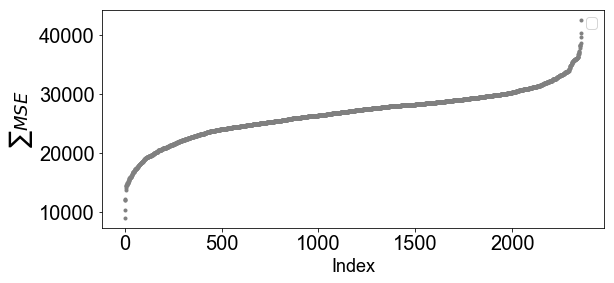

In [48]:
plotting.plt_idx_vs_mse(np.asarray(mse_M2c_all)[:,0], len(mse_M2c_all))

No handles with labels found to put in legend.


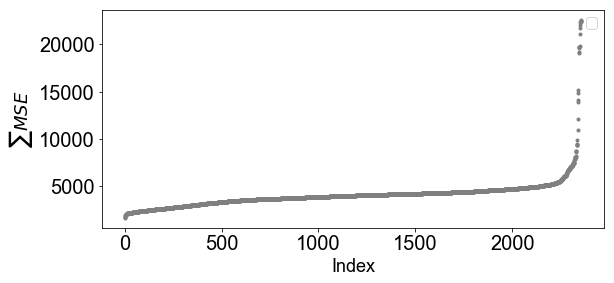

In [49]:
# top = 50
# plotting.plt_idx_vs_mse(np.asarray(mse_M4)[:top,0], len(last_mses_M4))
# plotting.plt_idx_vs_mse(np.asarray(mse_M4)[:top,50], len(last_mses_M4))
# plotting.plt_idx_vs_mse(np.asarray(mse_M4)[:,500], len(last_mses_M4))
# plotting.plt_idx_vs_mse(np.asarray(mse_M4)[:,1000], len(last_mses_M4))
plotting.plt_idx_vs_mse(np.asarray(mse_M2c_all)[:,1000], len(mse_M2c_all))
# plotting.plt_idx_vs_mse(last_mses_M4, len(last_mses_M4))
plt.show()

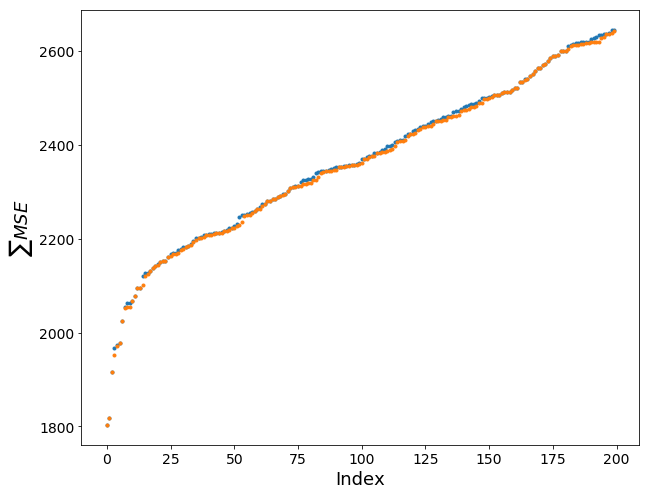

In [19]:
top = 200 # len(last_mses_M4)
# plotting.plt_idx_vs_mse(np.asarray(mse_M4)[:top,0], top)
# plotting.plt_idx_vs_mse(np.asarray(mse_M4)[:top,50], top)
# plotting.plt_idx_vs_mse(np.asarray(mse_M4)[:,500], top)
plotting.plt_idx_vs_mse(np.asarray(mse_M2c_all)[:,980], top)
plotting.plt_idx_vs_mse(np.asarray(mse_M2c_all)[:,1000], top)

(83.27081915737223, array([0], dtype=int64))

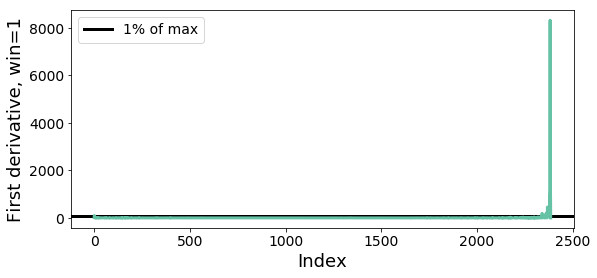

In [86]:
plotting.plt_deriv(last_mses_M2c_all,len(last_mses_M2c_all),len(last_mses_M2c_all), 1,1)

[39]


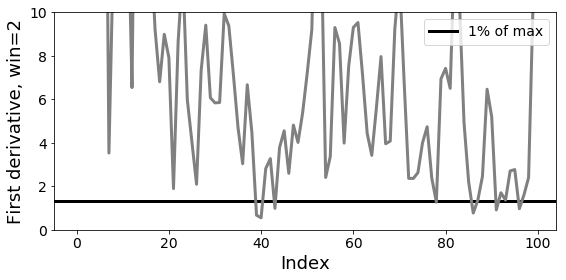

In [27]:
thresh_M2c, idx_thresh_M2c = plotting.plt_deriv(last_mses_M2c_all, 100,1000, 1,2)
plt.ylim(0,10)
print(idx_thresh_M2c)

(0, 5)

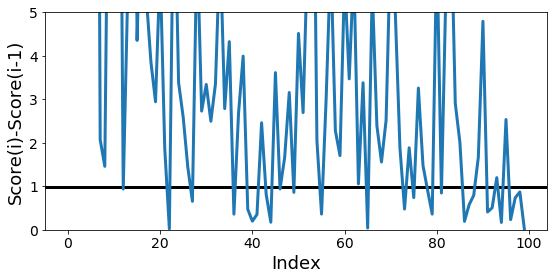

In [23]:
plotting.plt_deriv(last_mses_M2c_all, 100,1)

# thresh = 158.38711511863949*0.01
# print(thresh)
# print(z)
# np.argwhere(z<thresh)
plt.ylim(0,5)

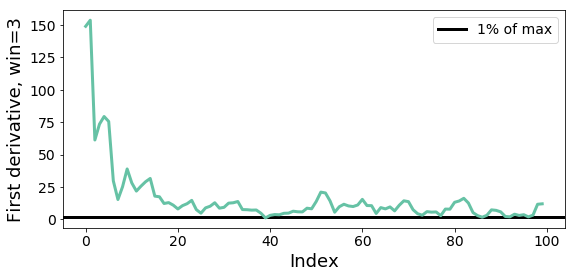

In [99]:
plotting.plt_deriv(last_mses_M2c_all, 100, 2000, 1, 3)
plt.savefig('C:/Users/sksuzuki/Downloads/first.png', dpi=300,bbox_inches='tight')

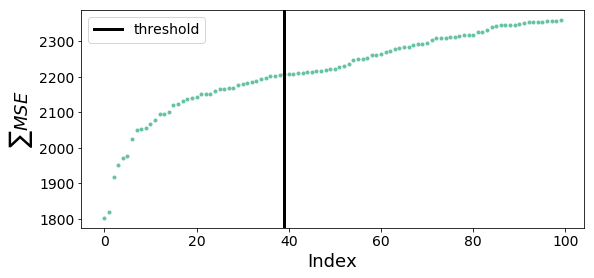

In [100]:
plotting.plt_idx_vs_mse(last_mses_M2c_all, 100, idx_thresh_M2c)
plt.savefig('C:/Users/sksuzuki/Downloads/thresh.png',  dpi=300,bbox_inches='tight')

In [50]:
select_top_M2c_all = top_params_M2c_all.copy()
# select_top_M2c_all = select_top_M2c_all[:idx_thresh_M2c[0]]

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1000.
  warnings.warn(msg, RuntimeWarning)


<Figure size 720x576 with 0 Axes>

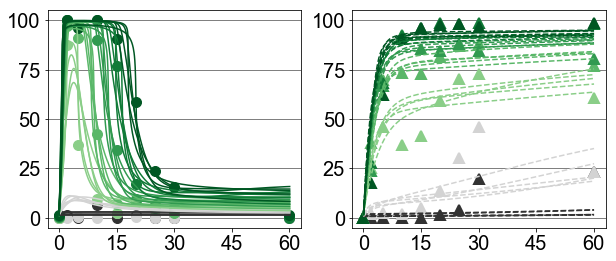

In [53]:
plotting.plt_param_behaviors(M2c_fxns, select_top_M2c_all, 5, params_constants, initials,  doses, time, 2, mapk_wt_data, ss=True, mapk_t100a_data=mapk_t100a_data, mapk_time=mapk_time)
# plt.savefig("C:/Users/sksuzuki/Documents/Research/figures/simulations/hog1.png",dpi=150,bbox_inches='tight')



C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1000.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


<Figure size 720x576 with 0 Axes>

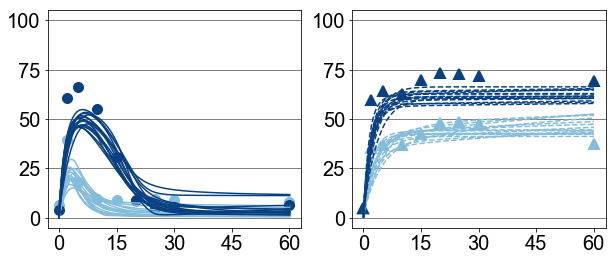

In [65]:
plotting.plt_param_behaviors(M2c_fxns, select_top_M2c_all, 15, params_constants, initials,  map2k_doses, time, 1, map2k_wt_data, ss=True, mapk_t100a_data=map2k_t100a_data, mapk_time=mapk_time)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1000.
  warnings.warn(msg, RuntimeWarning)


<Figure size 720x576 with 0 Axes>

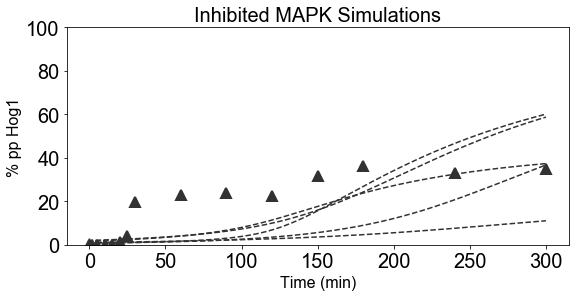

In [58]:
mapk_time_t100a_long = [0, 2, 5, 10, 15, 20, 25, 30, 60, 90, 120, 150, 180, 240, 300]

plotting.plt_t100a_long(M2c_fxns, select_top_M2c_all, 5, params_constants, initials, mapk_data_t100a_long[0], mapk_time_t100a_long)
# plotting.plt_t100a_long(M2c_fxns, select_top_M2c_all, 10, params_constants, initials, mapk_data_t100a_long[0], mapk_time_t100a_long, save_fig=model_folder+sim_id+'t100a_long')

<Figure size 720x576 with 0 Axes>

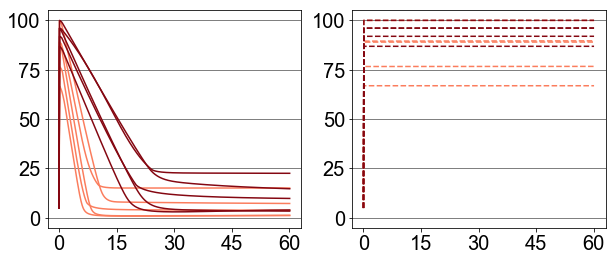

In [60]:
plotting.plt_param_behaviors(M2c_fxns, select_top_M2c_all, 5, params_constants, initials,  map2k_doses, time, 0)
# plotting.plt_param_behaviors(M2c_fxns, select_top_M2c_all, 10, params_constants, initials,  map2k_doses, time, 0, save_fig=model_folder+sim_id+'MAP3K')

<Figure size 720x576 with 0 Axes>

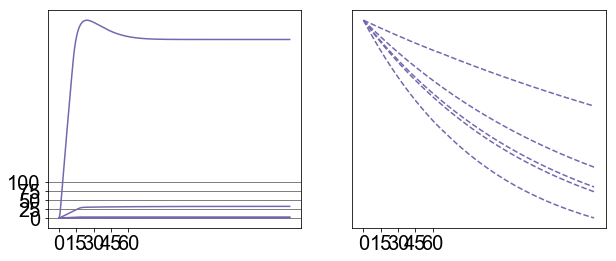

In [61]:
plotting.plt_param_behaviors(M2c_fxns, select_top_M2c_all, 5, params_constants, initials,  [350000], time, 3)
# plotting.plt_param_behaviors(M2c_fxns, select_top_M2c_all, 10, params_constants, initials,  [350000], time, 3, save_fig=model_folder+sim_id+'Osmolytes')

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1000.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


<Figure size 720x576 with 0 Axes>

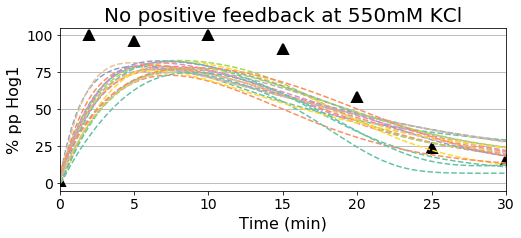

In [128]:
plotting.plt_nopos(M2c_fxns, select_top_M2c_all, idx_thresh_M2c[0], params_constants, initials, mapk_wt_data[6], mapk_time, 550000)
# plt.ylim(-2,102)
# plt.savefig("C:/Users/sksuzuki/Documents/Research/figures/simulations/nopos_550",dpi=150,bbox_inches='tight')

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1000.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


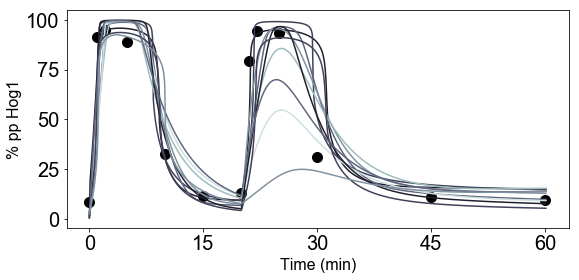

In [64]:
plotting.plt_ramp_behaviors(M2c_fxns, select_top_M2c_all, 10, params_constants, initials, time, 2, ss=True, hog1_ramp_data=hog1_ramp_data, mapk_ramp_time=mapk_ramp_time)
# plotting.plt_ramp_behaviors(M2c_fxns, select_top_M2c_all, 10, params_constants, initials, time, 2, hog1_ramp_data, mapk_ramp_time, save_fig=model_folder+sim_id+'ramp')

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1000.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


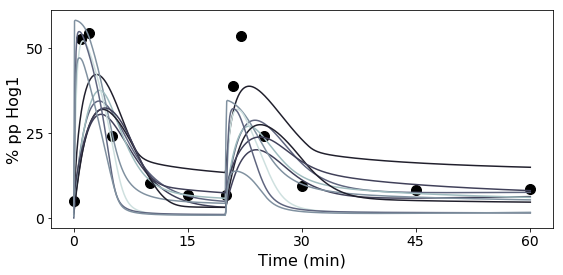

In [39]:
plotting.plt_ramp_behaviors(M2c_fxns, select_top_M2c_all, 10, params_constants, initials, time, 1,  pbs2_ramp_data, mapk_ramp_time)

<Figure size 720x576 with 0 Axes>

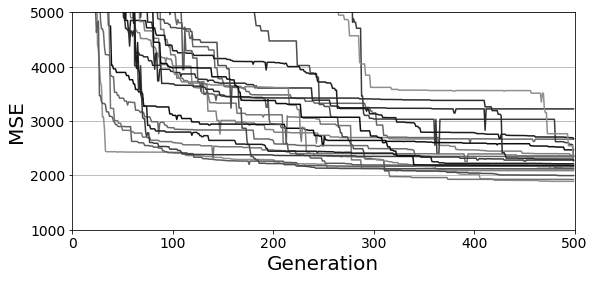

In [455]:
plotting.plt_mses_gen(gen,mse_M2c_all, idx_top_M2c_all)

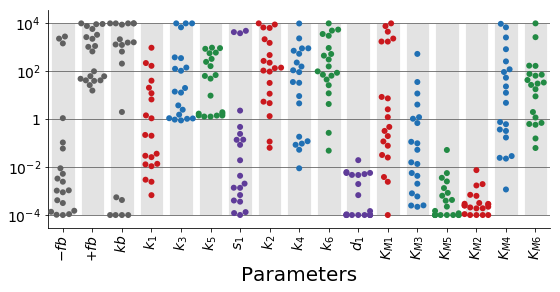

In [261]:
plotting.plt_param_ranges(labelnames, 'M2a', dims, df_top_params_log_M_M2c_all, save_fig=model_folder+sim_id+'params')

In [262]:
mses_M2c_all = model_supp.get_mse_stats(M2c_fxns, select_top_M2c_all, params_constants, initials, ptpD=False)
mses_M2c_all.head()

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1000.
  warnings.warn(msg, RuntimeWarning)


0          1           2          3          4          5   \
0   6.327707  40.877438   59.798231  95.499557  70.366891  96.306700   
1   5.534601  27.561781  294.099727  39.898174  15.931014  46.837833   
2  10.893616  51.447398   39.158687  42.050799  46.036466  28.612286   
3   5.368290   0.545520  226.198711  20.764874   2.802941   7.564917   
4   5.504743  25.088604   52.986564  57.231944  58.705442  43.083612   

          6           7           8           9          10          11  \
0  34.701250  158.870469  182.457230  103.903730  39.306015  105.909857   
1  19.754180  372.745147  249.059839  120.230458  24.838937   70.975444   
2  60.365161  329.242968  232.090952  133.308478  36.706149  105.417528   
3  22.416850  440.125814  398.193038  106.193419  29.017014   44.797997   
4  61.562585  441.690234  252.115473  111.893430  28.251210   56.117547   

           12          13          14         15          16          17  
0  134.134135  221.117788  215.087919  88.403031   91.695696  373.687802  
1   86.698247  148.208198  125.196782  59.622825  166.555817  686.695537  
2  118.277882  193.938874  237.671333  68.276036   94.045124   62.694145  
3   68.675362  122.069233  202.002481  48.814457   73.325437  626.926895  
4   51.819562  105.141379  333.983526  85.420569  158.003739  331.578179

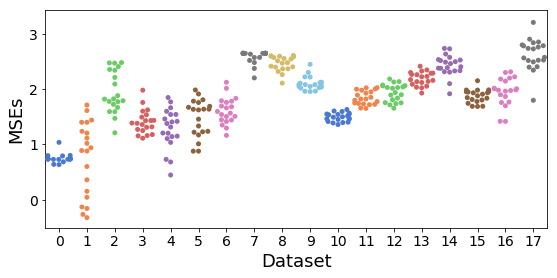

In [263]:
plotting.plt_mses_swarm(mses_M2c_all, save_fig='')

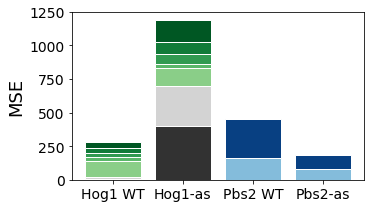

In [264]:
plotting.plt_mses(mses_M2c_all, (1,1, 1, 1, 0,0), size=(5,3), ptpD=False ,save_fig=model_folder+sim_id+'fit_mses')

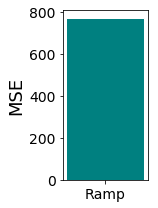

In [266]:
plotting.plt_mses(mses_M2c_hog1, (0,0, 0, 0, 1, 1), size=(2,3), ptpD=False ,save_fig=model_folder+sim_id+'predicted_mses')

$k_1$     $s_1$       0.594116
$s_1$     $k_1$       0.594116
$K_{M1}$  $kb$        0.657247
$kb$      $K_{M1}$    0.657247
$k_1$     $K_{M1}$    0.775277
$K_{M1}$  $k_1$       0.775277
$- fb$    $s_1$       0.973365
$s_1$     $- fb$      0.973365
$k_5$     $+ fb$      0.988809
$+ fb$    $k_5$       0.988809
dtype: float64


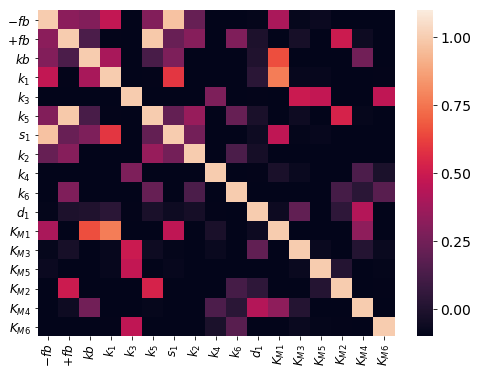

In [267]:
plotting.plt_corr(labelnames, df_top_params, save_fig=model_folder+sim_id+'corr')

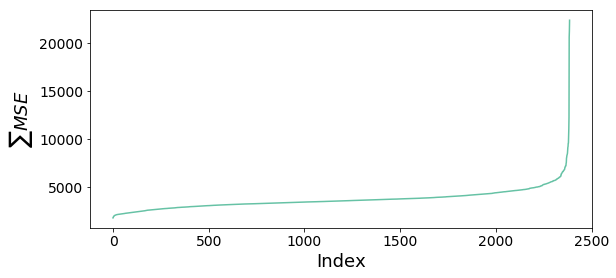

In [429]:
plotting.plt_idx_vs_mse(last_mses_M2c_all, len(last_mses_M2c_all))

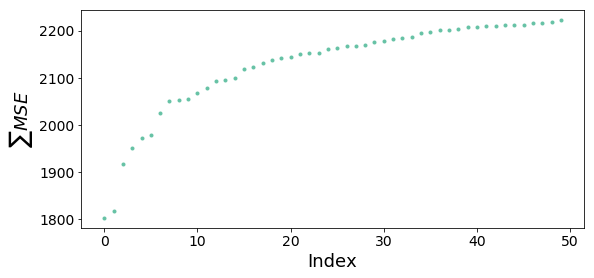

In [438]:
plotting.plt_idx_vs_mse(last_mses_M2c_all, 50)

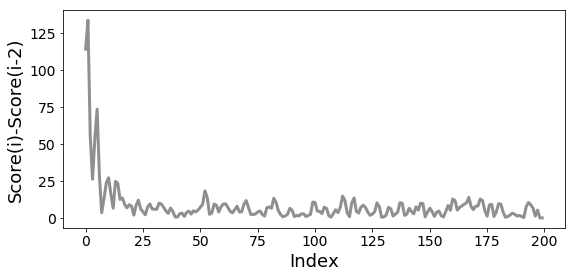

In [493]:
plotting.plt_deriv(last_mses_M2c_all,200,2)

### Save data

In [143]:
# save_sim_data(select_top_M4, doses, 2, path='C:/Users/sksuzuki/Documents/Research/figures/paper1/unsorted/', sim_name='M4_t100a', t100a=True)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [151]:
# save_sim_data(select_top_M4, doses, 2, path='C:/Users/sksuzuki/Documents/Research/figures/paper1/unsorted/', sim_name='M4_ramp', ramp=True)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


# Compare Models

In [40]:
def change_param(param_set, idx):
    param_sets = []
#     print(param_set[idx])
    for i in np.logspace(-4,4,8):
        new_param_set = param_set.copy()
#         print(i)
#         print(new_param_set[idx])
        new_param_set[idx] = new_param_set[idx]*i
#         print(new_param_set[idx])
        param_sets.append(new_param_set)
    return param_sets

In [165]:
b3 = change_param(best_fit, 0)
a1 = change_param(best_fit, 1)
a2 = change_param(best_fit, 2)
kb = change_param(best_fit, 3)
k1 = change_param(best_fit, 4)
k3 = change_param(best_fit, 5)
k5 = change_param(best_fit, 6)
s7 = change_param(best_fit, 7)
k9 = change_param(best_fit, 8)
k2 = change_param(best_fit, 9)
k4 = change_param(best_fit, 10)
d8 = change_param(best_fit, 11)
K1 = change_param(best_fit, 12)
K3 = change_param(best_fit, 13)
K5 = change_param(best_fit, 14)
K9 = change_param(best_fit, 15)
K2 = change_param(best_fit, 16)
K4 = change_param(best_fit, 17)
K6 = change_param(best_fit, 18)
K10 = change_param(best_fit, 19)
pPTP= change_param(best_fit, 20)

<Figure size 864x576 with 0 Axes>

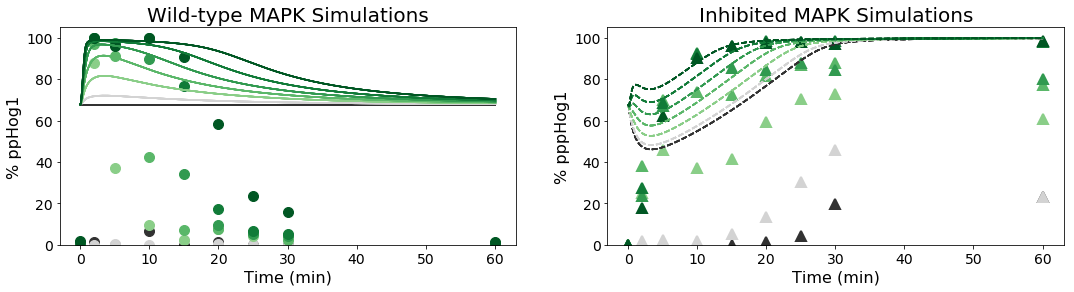

In [256]:
plt_param_behaviors(pPTP, 10, params_constants, initials, 5000, doses, time, 2, mapk_wt_data, mapk_t100a_data, mapk_time)

<Figure size 864x576 with 0 Axes>

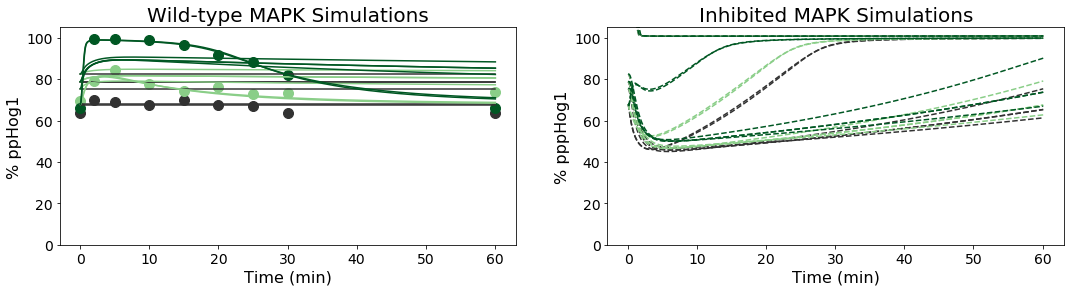

In [257]:
plt_param_behaviors_consts_diff(pPTP, 10, consts_diff, initials, 5000, [0]+map2k_doses, time, 2, mapk_ptp_data, None, mapk_time)

## Calculate Ttest

In [39]:
from scipy.stats import ttest_ind
ttest = ttest_ind(df_top_params_ptp23, df_df_top_params_all, axis=0)
print(ttest)

Ttest_indResult(statistic=array([ 2.39679427, -2.79229073, -1.32267715,  1.35465514, -0.54118825,
        1.7618635 , -1.96711273, -0.65253951, -2.92496233, -1.32407551,
        1.11084685,  3.27659218, -2.54644332, -0.51225341, -0.5430844 ,
       -0.64036423, -0.88305972, -0.81891478, -0.58938274,  5.35936213,
       13.22090904]), pvalue=array([1.73831097e-02, 5.69868390e-03, 1.87328616e-01, 1.76929721e-01,
       5.88930435e-01, 7.94939813e-02, 5.04386338e-02, 5.14740687e-01,
       3.80914011e-03, 1.86864583e-01, 2.67857974e-01, 1.22241783e-03,
       1.15725799e-02, 6.08992243e-01, 5.87626541e-01, 5.22608326e-01,
       3.78176751e-01, 4.13729348e-01, 5.56214849e-01, 2.11972735e-07,
       1.08039792e-29]))


Tukey's test (honing in on two comparisons of the group) for ANOVA (summary statistic comparing all of the groups) correcting for multiple testing https://cleverowl.uk/2015/07/01/using-one-way-anova-and-tukeys-test-to-compare-data-sets/

## Calculate score

In [290]:
hog1_doses = [0, 50000, 150000, 250000, 350000, 450000, 550000]
pbs2_doses = [150000, 550000]
ptp_doses = [0, 150000, 550000]

for params in top_params_a1_1D[:10]:
    print(scorefxn(initials, params_constants, params))

[0, 2, 5, 10, 15, 20, 25, 30, 60]
[0, 2, 5, 10, 15, 20, 25, 30, 60]
[0, 2, 5, 10, 15, 20, 25, 30, 60]
[0, 2, 5, 10, 15, 20, 25, 30, 60]
[0, 2, 5, 10, 15, 20, 25, 30, 60]
[0, 2, 5, 10, 15, 20, 25, 30, 60]
[0, 2, 5, 10, 15, 20, 25, 30, 60]
[0.0, 0.0, 0.0, 0.0, 0.0, 1.361472, 4.18506, 19.49207995, 23.08120093, 23.78618578, 22.3375094, 31.67199502, 36.30961501, 33.02963546, 34.87627365]


C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


ValueError: operands could not be broadcast together with shapes (9,) (15,) 